# Insurance Cross Selling

## Describing Dataset
[Link to the dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv)

Dataset information:
- **id**: unique identiﬁer of the client.
- **Gender**: gender of the client.
- **Age**: age of the client.
- **Driving_License**: 1 if the client holds a driver's license, 0 otherwise.
- **Region_Code**: unique code of the client's region of residence.
- **Previously_Insured**: 1 if the customer already has a vehicle insured, 0 otherwise.
- **Vehicle_Age**: age of the customer's vehicle.
- **Vehicle_Damage**: 1 if the customer has had accidents or vehicle damage in the past, 0 otherwise.
- **Annual_Premium**: annual insurance premium amount paid by the customer.
- **PolicySalesChannel**: channel used to sell the policy (e.g., email, telephone, in person).
- **Vintage**: days since the customer has been insured with AssurePredict.
- **Response**: 1 if the customer has accepted the cross-sell proposal, 0 otherwise.


**GOAL** : is to develop a machine learning model that predicts whether customers, who currently have health insurance, might be interested in taking out an insurance for their vehicle.

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools
from collections import Counter

#sklearn import
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, classification_report
from sklearn.feature_selection import mutual_info_classif

# imblearn import
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


# models
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#importing methods for model evaluation
#from sklearn import metrics

## Functions

In [2]:
def variables_type(df):
    '''
    Input pd.dataframe
    Return a tuple of 2 list (categorical and numerical varaibles)
    '''
    num = []
    cat = []
    for var in df.columns:
        if df[var].dtype==object:
            cat.append(var)
        elif set(df[var].unique()) == set([1,0]):
            cat.append(var)
        else:
            num.append(var)
    return (num, cat)

In [3]:
def count_outliers(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()

In [4]:
def sub_boxplots(df, var=None, subplot_cols=3, subplot_rows=None, fig_size=(15,10), hue=None):
    '''
    Print boxplots in subplot setting
    If hue is given as a categorical feature, the boxplot is showed according to that division
    '''
    if var is None:
        var = df.columns
    if subplot_rows is None:
        subplot_rows = math.ceil(len(var)/subplot_cols)
    
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(var):
        sns.boxplot(data = df, x=col, ax=axes[i], hue=hue, orient="h")
        
    plt.show()


In [5]:
def sub_stacked_hist(df, var=None, subplot_cols=3, subplot_rows=None, fig_size=(15,10), hue='target'):
    '''
    Plot staked hisrograms in suplot setting for the variables of a df
    hue is the variable on which the plotted feature is divided by color (defaul 'target') 
    '''
    if var is None:
        var = df.columns
    if subplot_rows is None:
        subplot_rows = math.ceil(len(var)/subplot_cols)
        
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(var):
        sns.histplot(data = df,x = col, ax=axes[i], hue=hue, multiple='stack')
        
    plt.show()
    

In [6]:
def plot_features_distribution(df, subplot_cols=3, fig_size=(15,10), boxplot=False):
    '''
    Take in input a df and the subplot cols
    Differentiate from categorical to numerical variables
    Plot the distribution of the features in the df
    Show the mean, the median and the skewness of the distribution
    If boxplot set True show the boxplots for num var
    '''
    num_var, cat_var = variables_type(df)
    
    # numerical var distribution subplot
    subplot_num_rows = math.ceil(len(num_var)/subplot_cols)
    fig, axes = plt.subplots(subplot_num_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(num_var):
        axes[i].hist(df[col], color='b', bins="rice", edgecolor ='black' ,alpha=0.7)
        axes[i].axvline(df[col].mean(), color='red', linestyle='-')
        axes[i].axvline(df[col].median(), color='g', linestyle='-')
        axes[i].set_title(col)
        skw = df[col].skew()
        axes[i].legend(['mean', 'median', 'skewness: {:.2f}'.format(skw)], loc='upper right')
    
    # show boxplot of numerical variables
    if boxplot:
        sub_boxplots(df, var=num_var, subplot_cols=subplot_cols, fig_size=fig_size)

    # categorical var histogram
    subplot_cat_rows = math.ceil(len(num_var)/subplot_cols)
    fig, axes = plt.subplots(subplot_num_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(cat_var):
        unique_values = df[col].unique()
        bins = np.arange(len(unique_values) + 1) - 0.5  
        axes[i].hist(df[col], bins=bins, color='b', edgecolor ='black' ,alpha=0.7, histtype='bar', rwidth=0.6,  align='mid')
        axes[i].set_xticks(unique_values)
        axes[i].set_title(col)

In [7]:
def cramers_v(x, y):
    '''
    Function calculates the Cramer's V index from Chi2 value
    Effect size of comparison (association) between 2 categorical variable
    '''
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def cramers_matrix(df):
    '''
    Creation of the correlation matrix with cramers values
    Input df with only categorical variables
    '''
    cols = df.columns
    matrix = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)

    for col1, col2 in itertools.combinations(cols, 2):
        cramers_value = cramers_v(df[col1], df[col2])
        matrix.loc[col1, col2] = cramers_value
        matrix.loc[col2, col1] = cramers_value  
    return matrix

In [8]:
def eta_squared_anova(cat, num):
    '''
    Computing the effect size of the one-way ANOVA test,
    Returns the eta-squared statistic  
    '''
    groups = [num[cat == level] for level in np.unique(cat)]
    f_stat, p_value = stats.f_oneway(*groups) 
    ss_between = sum(len(group) * (group.mean() - num.mean()) ** 2 for group in groups)
    ss_total = sum((num - num.mean()) ** 2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    return eta_squared

In [9]:
def h_squared_kw(cat, num):
    '''
    Computing the effect size of the Kruskal-Wallis test,
    Returns the H statistic normalized (eta-squared of KW test) 
    '''
    groups = [num[cat == level] for level in np.unique(cat)]
    h_stat, p_value = stats.kruskal(*groups)  
    n = len(num)
    h_squared = (h_stat / (n - 1)) if n > 1 else 0  
    return h_squared


In [10]:
def eta2_matrix(df, test='KW'):
    '''
    Input df with both variables (cat, num)
    Return the eta-squared value of the test
    test='ANOVA' if the numerical variables have normal distributions
    test='KW' if the test performed is the non-parametric Kruskal-Wallis (default)
    '''
    num_var, cat_var = variables_type(df)
    correlation_matrix = pd.DataFrame(index=cat_var, columns=num_var)

    if test == 'KW':
        for cat_col in cat_var:
            for num_col in num_var:
                correlation_matrix.loc[cat_col, num_col] = h_squared_kw(df[cat_col], df[num_col])
    elif test == 'ANOVA':
        for cat_col in cat_var:
            for num_col in num_var:
                correlation_matrix.loc[cat_col, num_col] = eta_squared_anova(df[cat_col], df[num_col])

    correlation_matrix = correlation_matrix.astype(float)
    return correlation_matrix

In [11]:
def heat_map(df, method, figsize=(10, 8), test='KW'):
    '''
    Plot an heatmap
    pd.DataFrame in input
    method = "num" return correlation between numerical variables with Pearson Correlation Index,
    method = "cat" return the intensity of the association between categorical variables with Cramer's V Index,
    method = "both" return the effect size of one-way ANOVA test (or Kruskal-Wallis) between cat e num variables with the eta-squared values
    test indicates if performed Kruskal-Wallis (KW) or ANOVA
    '''
    if method == "num":
        corr_matrix = df.corr()
        title_text = "Pearson correlation for numerical variables"
    elif method == "cat":
        corr_matrix = cramers_matrix(df)
        title_text = "Cramer's V index for categorical variables"
    elif method == "both":
        corr_matrix = eta2_matrix(df, test=test)
        title_text = "Eta-squared for numerical-categorical variables relations"

        
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f")
    plt.title(title_text)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)  
    plt.show()

In [12]:
def hp_correlations(x,y,test='chi2', corr_index='pearson', alpha=0.05):
    '''
    Input 2 distributions to compare in a hypothesis test
    H_0 : the 2 variables are independent (no correlation/association)
    Return a tuple with p_value and the test results (as dictionaries)
    test = 'chi2' for categorical variables (or num-cat), the variables need to be discrete
    test = 'num' for only numerical variables
    corr_index give the correlation index to use ('pearson' or 'spearman')    
    '''
    res=[]
    if test == 'chi2':
        tab = pd.crosstab(x,y)
        chi2, p_value, _, exp_freq = stats.chi2_contingency(tab)
        res = [{'chi2-stat':chi2}, {'freq-tab':tab}, {'expected-freq':exp_freq}]
    elif test == 'num':
        if corr_index == 'pearson':
            cor, p_value = stats.pearsonr(x, y)
        elif corr_index == 'spearman':
            cor, p_value = stats.spearmanr(x, y)
        res = [{'corr_index':cor}]
    

    if p_value<alpha:
        print(f"P-value: {p_value:.5f} < {alpha:.2f}, H_0 is rejected. The correlation between 2 variables is significantly different to 0.")
    else:
        print(f"P-value: {p_value:.5f} > {alpha:.2f}, H_0 isn't rejected.")

    return (p_value, res)

In [13]:
# Debug step with .fit/.transform
class DebugTransformStep(BaseEstimator, TransformerMixin):
    def __init__(self, name, feature_names=None):
        self.name = name
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"🔹 {self.name} - X shape: {X.shape}")
        if self.feature_names:
            return pd.DataFrame(X, columns=self.feature_names)
        return X

# Debug step with .fit_resample (without inheritance from SamplerMixin!)
class DebugResampleStep(BaseEstimator):
    def __init__(self, name):
        self.name = name

    def fit_resample(self, X, y):
        print(f"🔸 {self.name} - X shape: {X.shape}")
        y_series = pd.Series(y)
        print(f"   Class distribution: {y_series.value_counts().to_dict()}")
        return X, y
    
# Selector step with Mutual Information
class FeatureSelectorByMI(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.03):
        self.threshold = threshold
        self.selected_indices_ = None

    def fit(self, X, y):
        mi = mutual_info_classif(X, y)
        self.selected_indices_ = np.where(mi > self.threshold)[0]
        return self

    def transform(self, X):
        if hasattr(X, 'iloc'):  # DataFrame
            return X.iloc[:, self.selected_indices_]
        else:                   # numpy.array 
            return X[:, self.selected_indices_]

    def get_selected_indices(self):
        return self.selected_indices_
    
    from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Selector step from an external list of features
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Se X è un numpy array ma abbiamo i nomi, convertiamo in DataFrame
        if isinstance(X, pd.DataFrame):
            return X[self.feature_names]
        else:
            return pd.DataFrame(X, columns=self.feature_names)[self.feature_names]


In [14]:
def create_debug_pipeline(num_features, cat_features, model, over=True, combine=False, strategy=1, rand=42, debug=False):
    '''
    Creare a pipeline that controls the over/under-salmping
    model is the classifier object used in the pipeline
    over=True if you want random oversampling, or False for random undersampling
    over='smote' to use SMOTE oversampling
    combine (default False) set to a float is the PROPORTION OF UNDERSAMPLING combined with oversampling (even with smote)
    strategy accept values as proportions (0.5, 0.7) is related to minority class
    rand as random_state, default 42
    Return the pipeline
    '''
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])
    if over is True:
        pipeline = ImbPipeline(steps=[
            ('preprocessing', preprocessor),
            ('debug_transform', DebugTransformStep('After Preprocessing')),
            ('oversampling', RandomOverSampler(sampling_strategy=strategy, random_state=rand)),
            ('debug_resample', DebugResampleStep('After Oversampling')),
            ('classifier', model)
        ])
        if combine is False:
            pass
        else:
            steps = list(pipeline.steps)
            steps = steps[:4] + [
                ('undersampling', RandomUnderSampler(sampling_strategy=combine, random_state=rand)),
                ('debug_resample_under', DebugResampleStep('After Undersampling'))
            ] + steps[4:]
            pipeline = ImbPipeline(steps=steps)
            
    elif over is False:
        pipeline = ImbPipeline(steps=[
            ('preprocessing', preprocessor),
            ('debug_transform', DebugTransformStep('After Preprocessing')),
            ('undersampling', RandomUnderSampler(sampling_strategy=strategy, random_state=rand)),
            ('debug_resample', DebugResampleStep('After Undersampling')),
            ('classifier', model)
        ])
        
    elif over == 'smote':
        pipeline = ImbPipeline(steps=[
            ('preprocessing', preprocessor),
            ('debug_transform', DebugTransformStep('After Preprocessing')),
            ('smote', SMOTE(sampling_strategy=strategy, random_state=rand)),
            ('debug_resample', DebugResampleStep('After SMOTE')),
            ('classifier', model)
        ])
        if combine is False:
            pass
        else:
            steps = list(pipeline.steps)
            steps = steps[:4] + [
                ('undersampling', RandomUnderSampler(sampling_strategy=combine, random_state=rand)),
                ('debug_resample_under', DebugResampleStep('After Undersampling'))
            ] + steps[4:]
            pipeline = ImbPipeline(steps=steps)
    
    if not debug:
        steps_clean = [step for step in pipeline.steps if 'debug' not in step[0]]
        pipeline = ImbPipeline(steps=steps_clean)

    return pipeline

In [15]:
def set_model_name(model, over=None, under=None):
    name = [str(model)]
    if over is None:
        name.append({'over':'/'})
    else:
        name.append({'over':over})
        
    if under is None:
        name.append({'under':'/'})
    else:
        name.append({'under':under})
    return name

In [16]:
def save_report_in_df(y_test, y_pred, y_proba, model_name):
    '''
    Input test and prediction of a ML model
    Return a pd.dataframe with the metrics in the report
    '''
    report = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame.from_dict(report).transpose()
    report.insert(0,'Model', [model_name[0] for _ in range(len(report))])
    report.insert(1,'over', [model_name[1].get('over') for _ in range(len(report))])
    report.insert(2,'under', [model_name[2].get('under') for _ in range(len(report))])

    acc = report.loc['accuracy', 'support']
    report.insert(len(report.columns),'accuracy', [acc for _ in range(len(report))])
    report = report.drop('accuracy')    
    roc_auc = roc_auc_score(y_test, y_proba)
    report.insert(len(report.columns),'roc_auc', [roc_auc for _ in range(len(report))])
    
    return report

In [17]:
def resampling_test(model, mod_str, num_features, cat_features, X_train, X_test, y_train, y_test, report, proportions, debug=False):
    # loop for UNDERSAMPLING
    for prop in proportions:
        pipeline_under = create_debug_pipeline(num_features, cat_features, model=model, over=False, strategy=prop, debug=debug)
        pipeline_under.fit(X_train, y_train)
        y_pred = pipeline_under.predict(X_test)
        y_proba = pipeline_under.predict_proba(X_test)[:,1]
        name = set_model_name(mod_str,under=prop)
        report = pd.concat([report, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
        print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
        
    # loop for OVERSAMPLING
    for prop in proportions:
        pipeline_over = create_debug_pipeline(num_features, cat_features, model=model, over=True, strategy=prop, debug=debug)
        pipeline_over.fit(X_train, y_train)
        y_pred = pipeline_over.predict(X_test)
        y_proba = pipeline_over.predict_proba(X_test)[:, 1]
        name = set_model_name(mod_str,over=prop)
        report = pd.concat([report, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
        print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
        
    # loop for smote
    for prop in proportions:
        pipeline_smote = create_debug_pipeline(num_features, cat_features, model=model, over='smote', strategy=prop, debug=debug)
        pipeline_smote.fit(X_train, y_train)
        y_pred = pipeline_smote.predict(X_test)
        y_proba = pipeline_smote.predict_proba(X_test)[:, 1]
        name = set_model_name(mod_str,over='smote '+str(prop))
        report = pd.concat([report, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
        print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
        
    # loop for smote + undersampling
    for prop in [0.5,0.6,0.7]:
        pipeline_smote = create_debug_pipeline(num_features, cat_features, model=model, over='smote', strategy=0.3, combine=prop, debug=debug)
        pipeline_smote.fit(X_train, y_train)
        y_pred = pipeline_smote.predict(X_test)
        y_proba = pipeline_smote.predict_proba(X_test)[:, 1]
        name = set_model_name(mod_str,over='smote 0.3', under=prop)
        report = pd.concat([report, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
        print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
        
    return report

In [18]:
def evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name=None):
    '''
    Calcualte the 4 main metrics accuracy, f1-score, recall, roc_auc
    Print the evaluation on over/under fitting 
    Return a tuple with train_metrics and test_metrics dictionaries
    '''
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    try:
        y_proba_train = pipeline.predict_proba(X_train)[:, 1]
        y_proba_test = pipeline.predict_proba(X_test)[:, 1]
        roc_auc_train = roc_auc_score(y_train, y_proba_train)
        roc_auc_test = roc_auc_score(y_test, y_proba_test)
    except:
        roc_auc_train = None
        roc_auc_test = None
        
    train_metrics = {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'f1': f1_score(y_train, y_pred_train),
            'recall': recall_score(y_train, y_pred_train),
            'roc_auc': roc_auc_train,
        }
    test_metrics = {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'f1': f1_score(y_test, y_pred_test),
            'recall': recall_score(y_test, y_pred_test),
            'roc_auc': roc_auc_test,
        }

    diagnosis = {}
    
    # internal functionto analyze the gap 
    def analyze_gap(train, test, threshold_gap, threshold_under):
        gap = train - test
        if train < threshold_under and test < threshold_under:
            return "Underfitting"
        elif gap > threshold_gap:
            return "Overfitting"
        else:
            return "Good generalization"

    diagnosis['roc_auc'] = analyze_gap(train_metrics['roc_auc'], test_metrics['roc_auc'], threshold_gap=0.05, threshold_under=0.7)
    diagnosis['recall'] = analyze_gap(train_metrics['recall'], test_metrics['recall'], threshold_gap=0.10, threshold_under=0.5)
    diagnosis['f1'] = analyze_gap(train_metrics['f1'], test_metrics['f1'], threshold_gap=0.08, threshold_under=0.5)
    diagnosis['accuracy'] = analyze_gap(train_metrics['accuracy'], test_metrics['accuracy'], threshold_gap=0.05, threshold_under=0.6)

    # print results
    print(f'{mod_name} evaluation:')
    for metric, evaluation in diagnosis.items():
        print(f"{metric.upper()}: {evaluation}")

    return (train_metrics, test_metrics)

In [19]:
def mi_score(x, y):
    '''
    Applycation of Mutual Information on a dataset
    x: Data that Mutual Information will be applyed
    y: Data used as 'reference' for the Mutual Information
    '''
    mi_score = mutual_info_classif(x, y, discrete_features='auto')
    mi_score = pd.Series(mi_score, index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [20]:
def clean_feature_names(df):
    df.columns = df.columns.str.replace(r'[\[\]<>]', '_', regex=True)
    return df

## Load Dataset

In [21]:
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv"
df = pd.read_csv(DATASET_URL)
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


# EDA
## Overview

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [23]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

🔔 There aren't missing values on the 381109 records

In [24]:
# id analysis 
df['id'].unique

<bound method Series.unique of 0              1
1              2
2              3
3              4
4              5
           ...  
381104    381105
381105    381106
381106    381107
381107    381108
381108    381109
Name: id, Length: 381109, dtype: int64>

🔔 Every record represent a different client so the **id** variable isn't useful to the model prediction.

In [25]:
df = df.drop(columns='id')

## Univariate Analysis

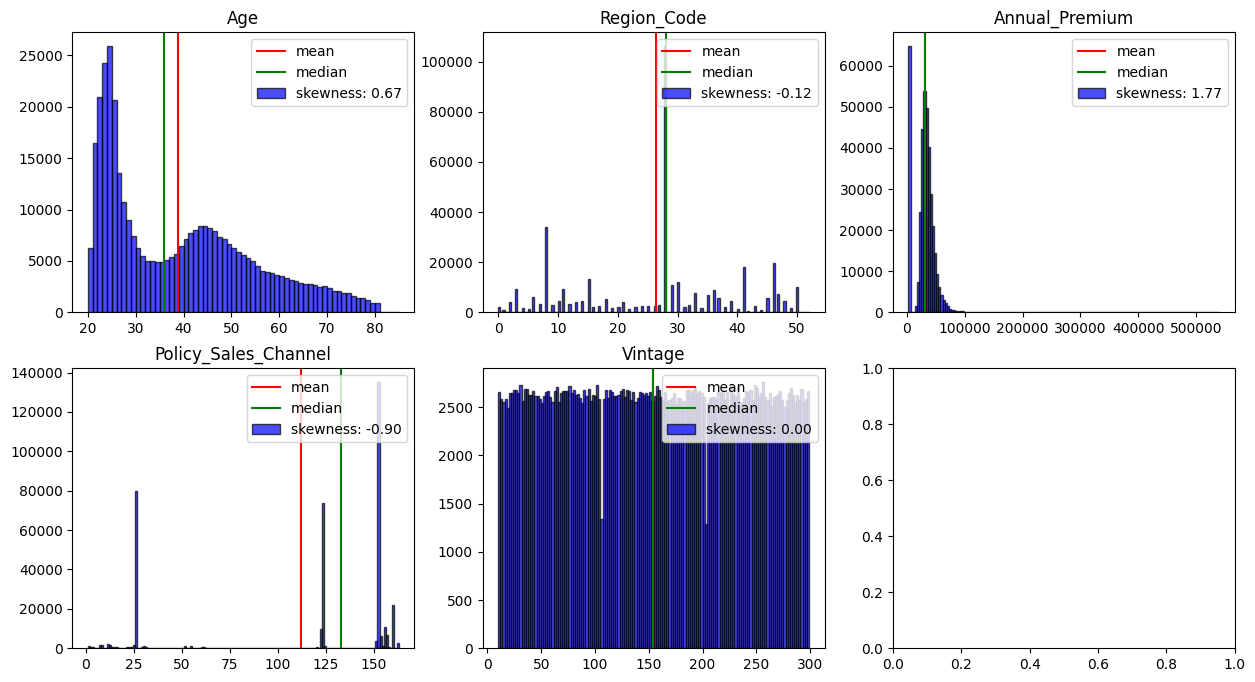

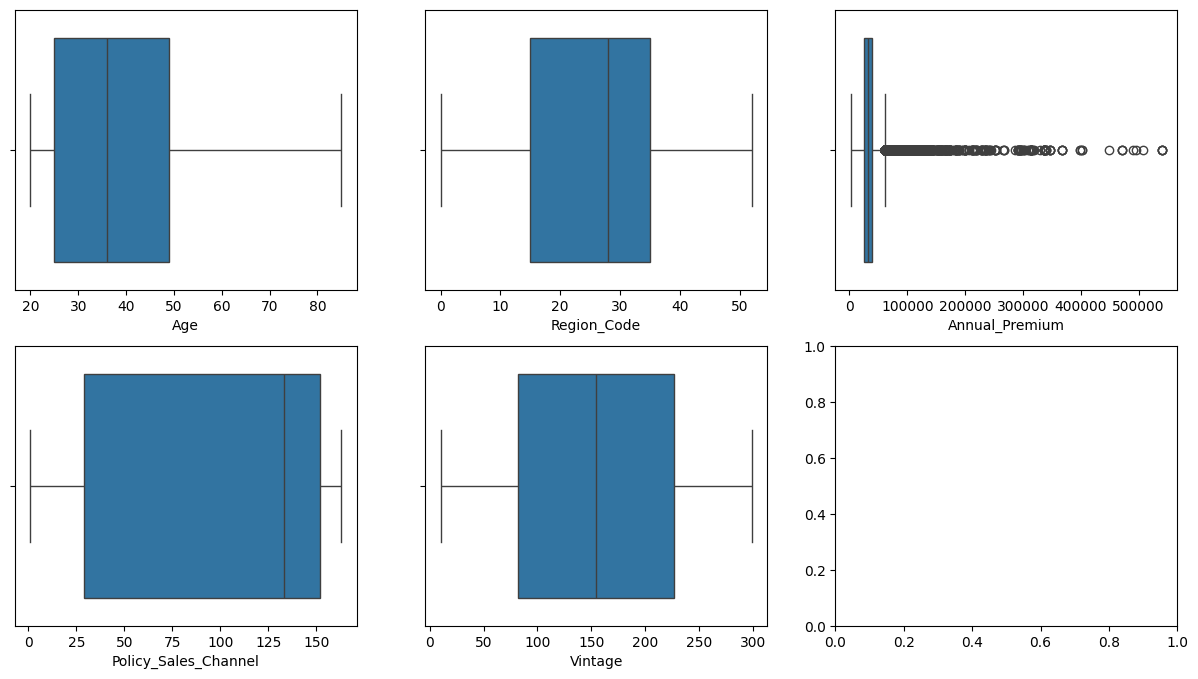

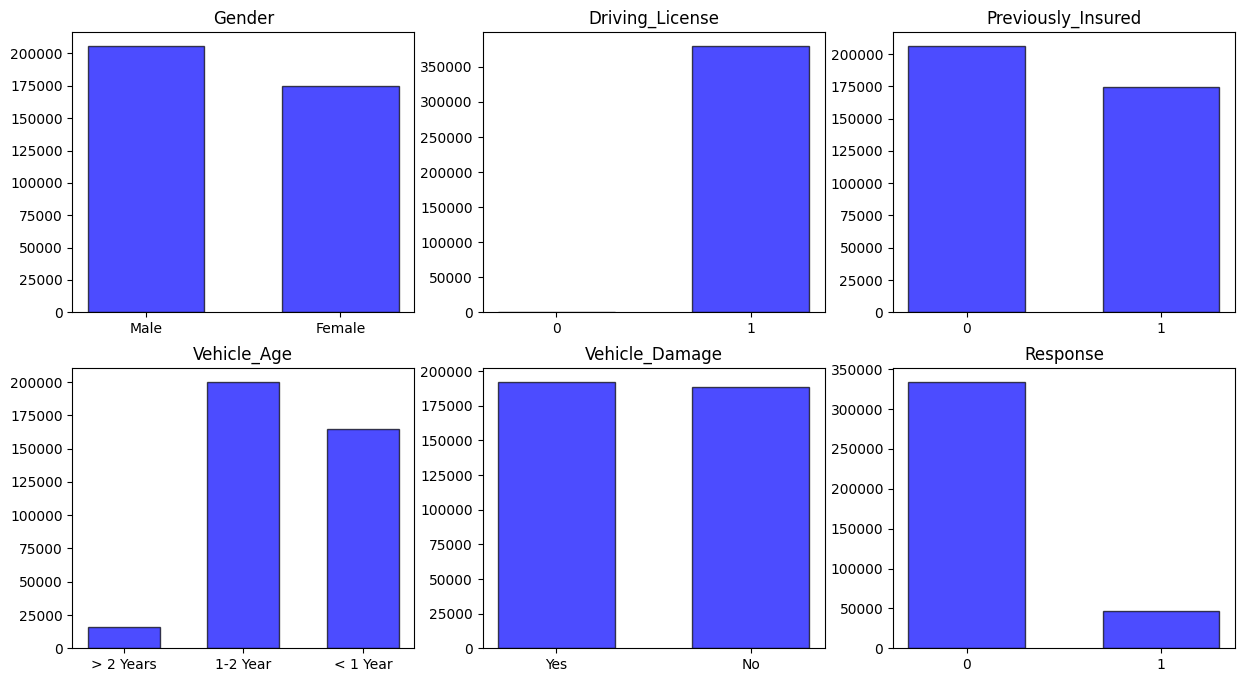

In [26]:
plot_features_distribution(df, fig_size=(15,8), boxplot=True)

In [27]:
num_var, cat_var = variables_type(df)
df_num = df.drop(columns=cat_var)
df_cat = df.drop(columns=num_var)

In [28]:
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0


In [29]:
df_cat_summary = (df_cat.melt(id_vars=[], value_vars=cat_var, var_name="Variable", value_name="Values")
                .groupby(["Variable", "Values"])
                .size()
                .reset_index(name="Counting")
                .sort_values(by=['Variable', 'Counting'], ascending=[True, False]))

display(df_cat_summary)


,Variable,Values,Counting
1,Driving_License,1,380297
0,Driving_License,0,812
3,Gender,Male,206089
2,Gender,Female,175020
4,Previously_Insured,0,206481
5,Previously_Insured,1,174628
6,Response,0,334399
7,Response,1,46710
8,Vehicle_Age,1-2 Year,200316
9,Vehicle_Age,< 1 Year,164786


In [30]:
outlier_count = count_outliers(df['Annual_Premium'])
print(f"Counting outlier of Annual_Premium: {outlier_count}, {round(outlier_count/len(df), 2)}%")

Counting outlier of Annual_Premium: 10320, 0.03%


🔔 Distributions insight

The numerical variable distributions are very different and mostly asymmetric (only *Vintage* shows skewness equal 0). 
- *Annual Premium* shows a lot of outliers (10320, 0.03% of the total records) in the upper limit of the distribution looking at the boxplot.
- From the histogram we can see some *Region Code* are more frequent as with some *Policy Sales Channel*. 
- *Age* shows 2 modes: one with a much higher count in the young range (between 20 and 30), a second one in the middle age (between 40 and 50).

About categorical variables the *Gender*, *Vehicle Damage* and *Previous Insured* are well balanced, while the target variable **Response** is highly unbalanced (need to manage for the classification model). 

There are 812 clients with no *Driving Licence*, but the vast majority has it.

## Multivariate Analysis

### Pair plot & Heatmap

Correlation between numerical variables

In [31]:
#sns.pairplot(df, hue='Response', corner=True, vars = df_num.columns)

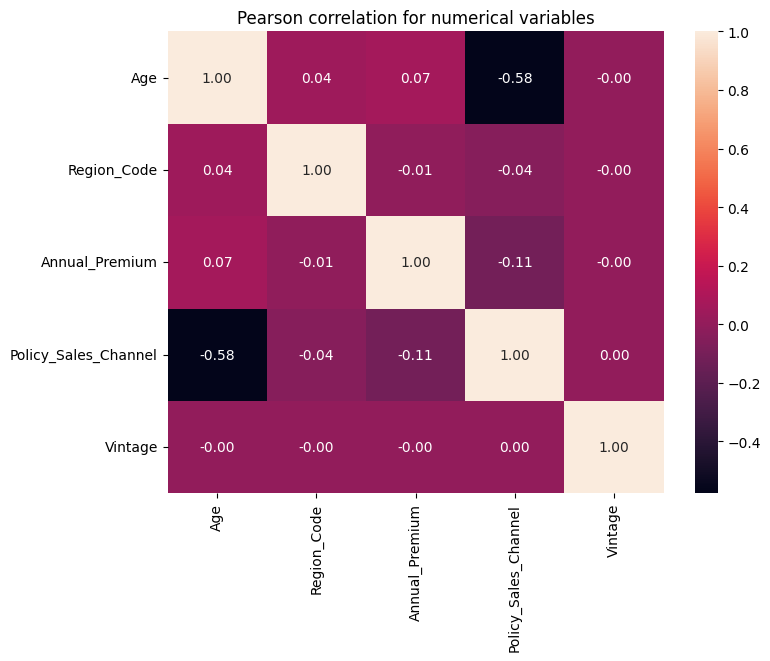

In [32]:
heat_map(df_num, method="num", figsize=(8,6))

Relation between categorical variables

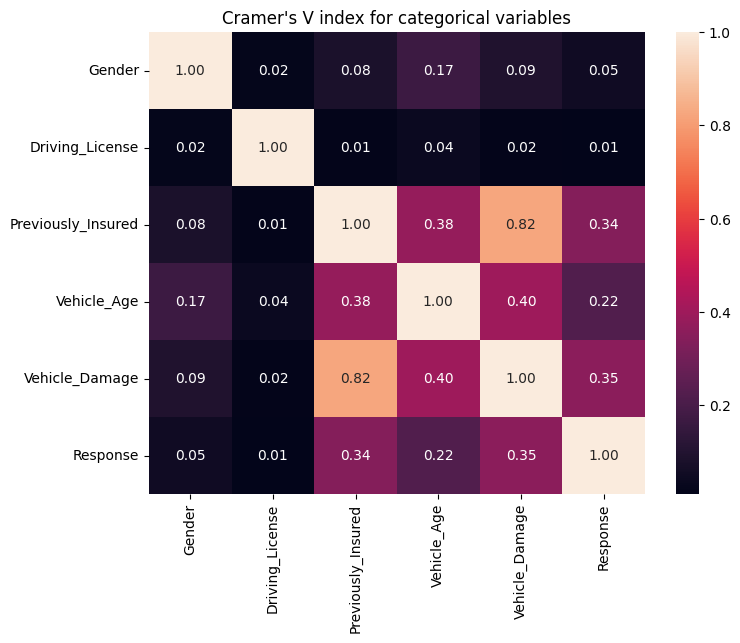

In [33]:
heat_map(df_cat, method="cat", figsize=(8,6))

Relation between categorical and numerical variables

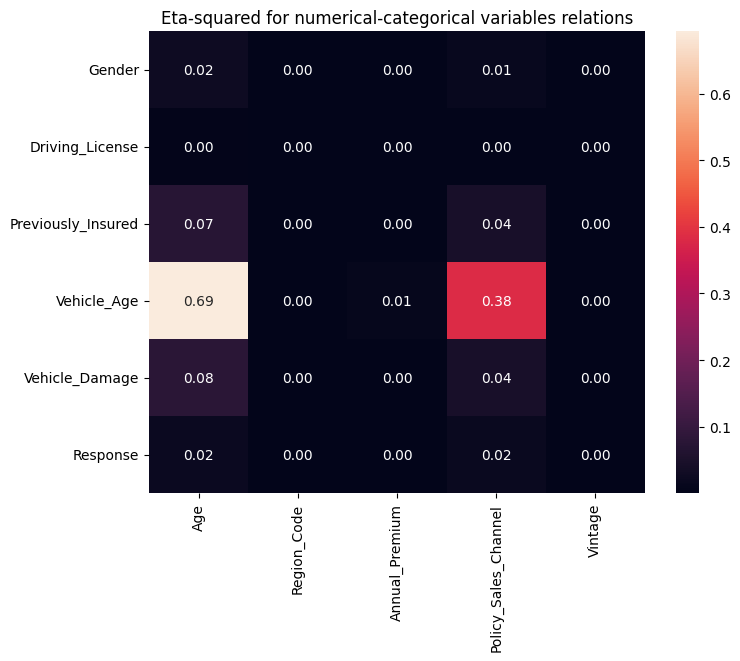

In [34]:
heat_map(df, method="both", figsize=(8,6))

In [35]:
#review
# capire se policy channel è possibile escluderla

🔔 Correlation insight

From the scatterplot based on the target variable values separation we can assert:
- there isn't any visible correlation between the numerical variables;
- the target's values distribution in each numerical variable seem to have the same shape but for *Response* = 1 there are lower levels. 

From the heatmaps we can see:
- for the numerical variables only a substantial correletion between *Age* and *Policy_Sales_Channel* (-0.58);
- for the categorical variables there is a possible correlation between *Previously_Insured* and *Vehicle_Damege* (cramers V index = 0.82)
- for categorical-numerical variables a hard relation could be *Vehicle_Age*-*Age* ($ H^2=0.69 $) and *Vehicle_Age*-*Policy_Sales_Channel* ($ H^2=0.38 $)

NB: $ H^2 $ is the proportion of the explained variance calculated from Kruskal-Wallis test (similar to the measure of the $ \eta^2 $ for the ANOVA test)

### Boxplot target variable conditioning

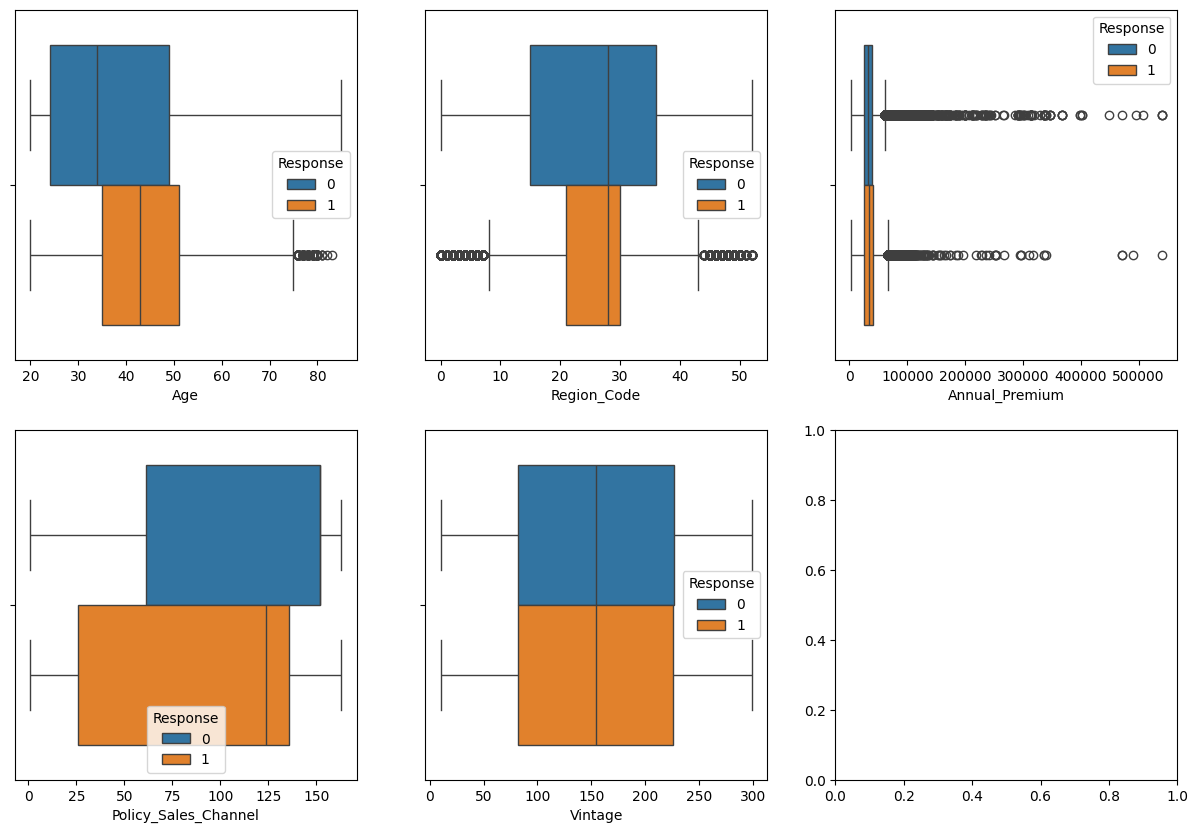

In [36]:
sub_boxplots(df, var=num_var, hue='Response')

🔔 Distribution insight related to target values

From the boxplots we can see in *Policy_Sales_Channel* and *Age* some differences in the values distribution as the target changes.

### Stacked histogram based on target feature values

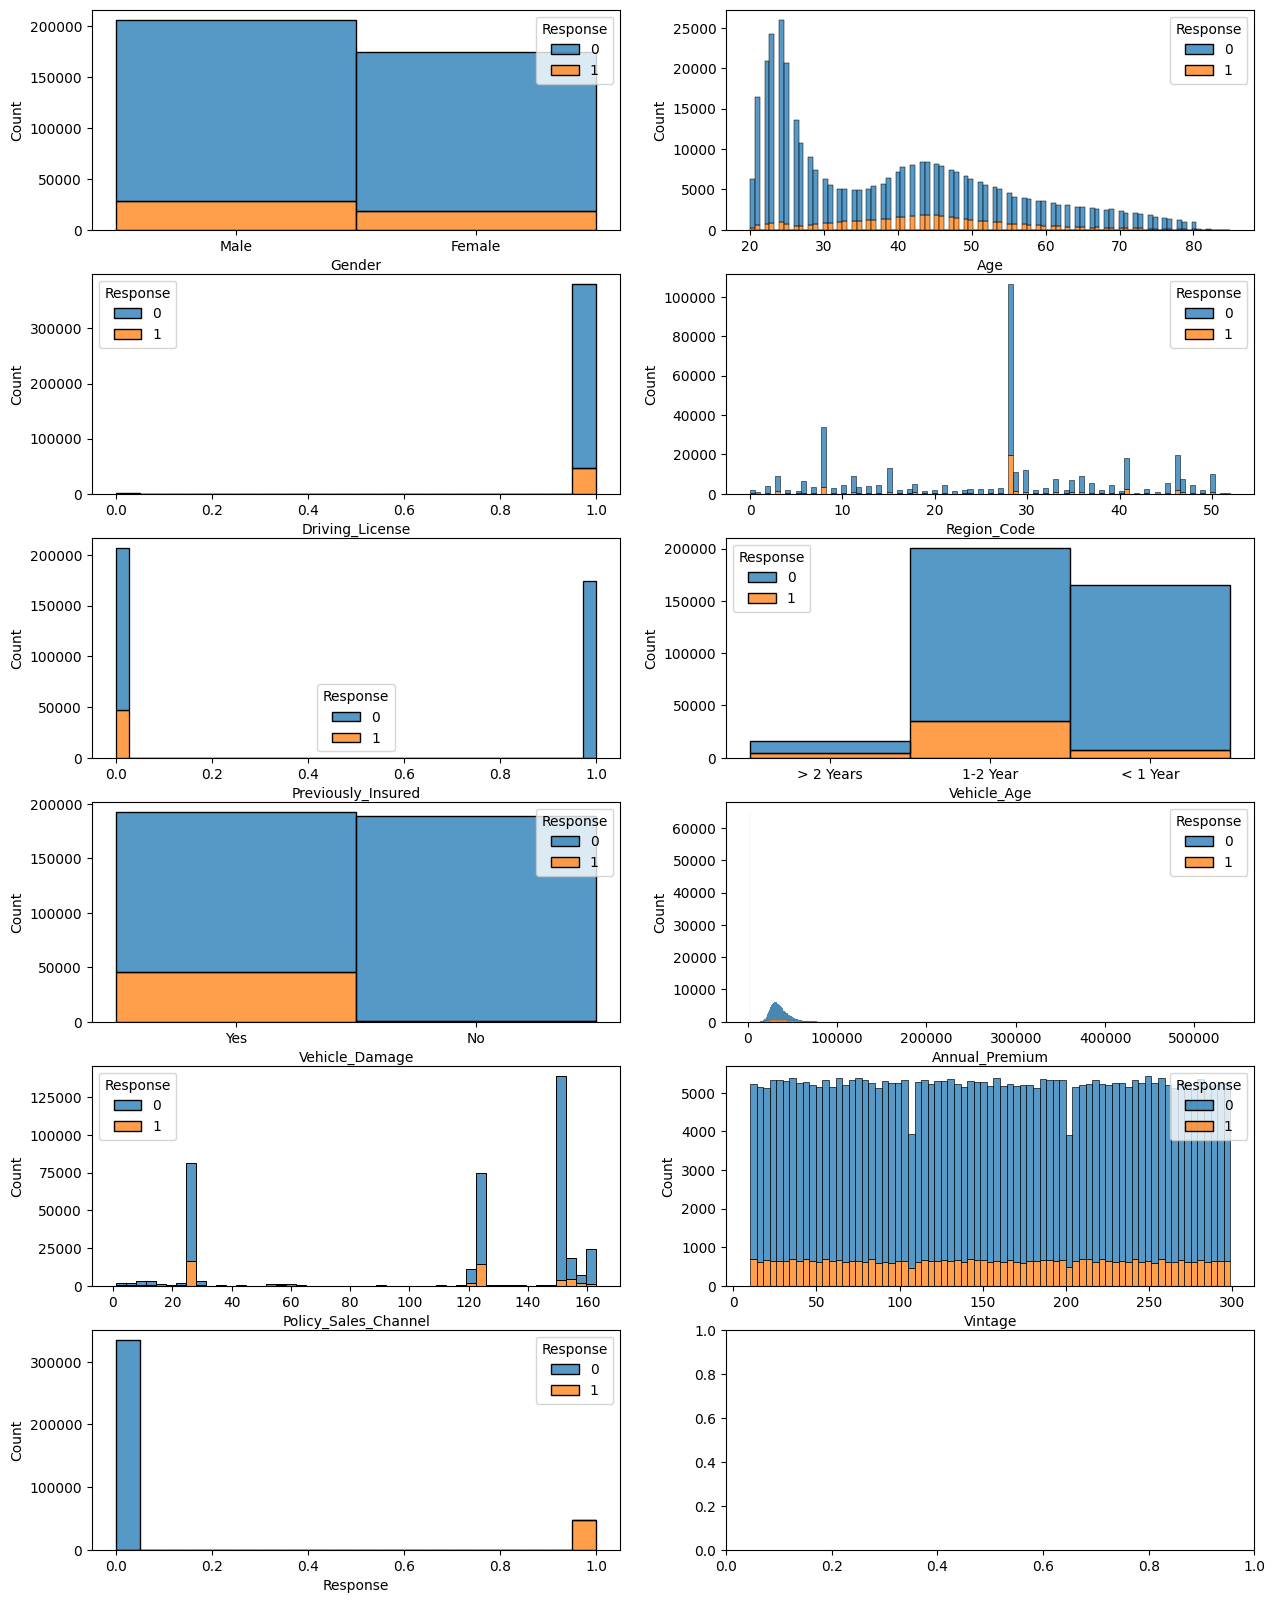

In [37]:
sub_stacked_hist(df, subplot_cols=2, fig_size=(15,20), hue='Response')

🔔 There aren't hard visible correlations in the variables divided by the target values in the staked histograms view and don't give us information about the predictive power of the variables (maybe due to the unbalanced classes in the target).

### Hypothesis testing

We're goning to check some hypothesis to verify the assumptions done thanks to the visualizations.
- Test Chi2 for discrete variables  -> cat-cat or num(discretized)-cat
- Correlation (Pearson/Spearman) for continuous vairables -> num-num

$H_0$: No correlation ($corr=0$) between the variables *Age* and  *Policy_Sales_Channel*

In [38]:
hp_correlations(df['Age'], df['Policy_Sales_Channel'], test='num', corr_index='pearson')

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0), [{'corr_index': np.float64(-0.5778255261514704)}])

$H_0$: No association (are independent) between the variables *Previus_Insured* and *Vehicle_Damage*

In [39]:
hp_correlations(df['Previously_Insured'], df['Vehicle_Damage'], test='chi2')

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(258850.16696408694)},
  {'freq-tab': Vehicle_Damage          No     Yes
   Previously_Insured                
   0                    23990  182491
   1                   164706    9922},
  {'expected-freq': array([[102233.58350498, 104247.41649502],
          [ 86462.41649502,  88165.58350498]])}])

$H_0$: No association (are independent) between the variables *Age* and *Vehicle_Age*

In [40]:
age_discr = pd.cut(df['Age'],10)
hp_correlations(age_discr, df['Vehicle_Age'])

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(336347.53375365236)},
  {'freq-tab': Vehicle_Age     1-2 Year  < 1 Year  > 2 Years
   Age                                          
   (19.935, 26.5]      3614    124388         38
   (26.5, 33.0]        9580     39262         99
   (33.0, 39.5]       31138       480        857
   (39.5, 46.0]       52549       239       2979
   (46.0, 52.5]       35366       194       3287
   (52.5, 59.0]       26925       116       3225
   (59.0, 65.5]       16452        58       2194
   (65.5, 72.0]       14716        34       2004
   (72.0, 78.5]        8250        13       1099
   (78.5, 85.0]        1726         2        225},
  {'expected-freq': array([[67299.54065635, 55362.63756563,  5377.82177802],
          [25724.04576119, 21161.3780467 ,  2055.57619211],
          [17069.29539843, 14041.71864217,  1363.9859594 ],
          [29311.88287865, 24112.84137084,  2342.27575051],
          [20418.50402903, 16796.87895589,  1631.61701508],
          [159

$H_0$: No association (are independent) between the variables *Vehicle_Age* and *Policy_Sales_Channel*

In [41]:
policy_discr = pd.cut(df['Policy_Sales_Channel'], 10)
hp_correlations(policy_discr, df['Vehicle_Age'])

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(225834.02641856577)},
  {'freq-tab': Vehicle_Age           1-2 Year  < 1 Year  > 2 Years
   Policy_Sales_Channel                               
   (0.838, 17.2]             9676      1139        744
   (17.2, 33.4]             74014      4979       7537
   (33.4, 49.6]               647        10         55
   (49.6, 65.8]              3614        22        304
   (65.8, 82.0]               115         1          7
   (82.0, 98.2]               421         5         23
   (98.2, 114.4]              570        29         33
   (114.4, 130.6]           76753      4071       5565
   (130.6, 146.8]            1055        38         45
   (146.8, 163.0]           33451    154492       1694},
  {'expected-freq': array([[6.07556537e+03, 4.99794383e+03, 4.85490799e+02],
          [4.54813281e+04, 3.74143161e+04, 3.63435581e+03],
          [3.74236746e+02, 3.07858466e+02, 2.99047884e+01],
          [2.07091682e+03, 1.70359881e+03, 1.65484363e+02],
  

$H_0$: No association (are independent) between the variables *Response* and *Policy_Sales_Channel*

In [42]:
hp_correlations(policy_discr, df['Response'])

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(14061.497321524184)},
  {'freq-tab': Response                   0      1
   Policy_Sales_Channel               
   (0.838, 17.2]          10184   1375
   (17.2, 33.4]           69629  16901
   (33.4, 49.6]             602    110
   (49.6, 65.8]            3453    487
   (65.8, 82.0]             108     15
   (82.0, 98.2]             384     65
   (98.2, 114.4]            563     69
   (114.4, 130.6]         70412  15977
   (130.6, 146.8]          1012    126
   (146.8, 163.0]        178052  11585},
  {'expected-freq': array([[1.01422901e+04, 1.41670989e+03],
          [7.59245924e+04, 1.06054076e+04],
          [6.24734887e+02, 8.72651131e+01],
          [3.45710036e+03, 4.82899643e+02],
          [1.07924707e+02, 1.50752934e+01],
          [3.93969051e+02, 5.50309492e+01],
          [5.54539956e+02, 7.74600442e+01],
          [7.58008738e+04, 1.05881262e+04],
          [9.98522895e+02, 1.39477105e+02],
          [1.66394452e+05, 2.32425481e

$H_0$: No association (are independent) between the variables *Response* and *Age*

In [43]:
hp_correlations(age_discr, df['Response'])

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(19563.10715380452)},
  {'freq-tab': Response             0      1
   Age                          
   (19.935, 26.5]  123509   4531
   (26.5, 33.0]     43416   5525
   (33.0, 39.5]     25301   7174
   (39.5, 46.0]     43853  11914
   (46.0, 52.5]     31027   7820
   (52.5, 59.0]     25184   5082
   (59.0, 65.5]     16375   2329
   (65.5, 72.0]     15224   1530
   (72.0, 78.5]      8682    680
   (78.5, 85.0]      1828    125},
  {'expected-freq': array([[112346.98723987,  15693.01276013],
          [ 42942.62654254,   5998.37345746],
          [ 28494.75484704,   3980.24515296],
          [ 48932.00903941,   6834.99096059],
          [ 34085.78110987,   4761.21889013],
          [ 26556.49731179,   3709.50268821],
          [ 16411.57489327,   2292.42510673],
          [ 14700.57344749,   2053.42655251],
          [  8214.56181302,   1147.43818698],
          [  1713.6337557 ,    239.3662443 ]])}])

In [44]:
#review
# capire se policy channel è possibile escluderla

🔔 Hypothesis test considerations:

All the hypothesis tests performed got rejected the null hp, so there are significant relations. In the chi-squared tests all the expected frequencies are greater than 30 so we can consider the tests robust.

On the target values the *Age* and *Policy_Sales_Channel* have different distributions so could be features with good predictive power. Those 2 also have a moderate correlation that could give some redundance in the prediction (but we don't exclude features at first).

# Pre-Processing

There are no missing values so that step is overtaken

**Pipeline for numerical variables** 
- Standardization

**Pipeline for categorical variables**
- One-hot encoding

In [45]:
X = df.drop('Response', axis=1)
y = df['Response']
num_features, cat_features = variables_type(X)

In [46]:
num_features

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [47]:
cat_features

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

In [124]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# Classification Model

📊 **Performance metrics considerations**

In general the accuracy metric for a classification model is a good overall metric to assess the performance, but in the case of an imbalance dataset could be misleading. So we need to take into account other metrics.

The goal For the business case is to predict if a customer will accept the cross-selling offer. The best way to optimize this goal would be to minimize the *False Negative* for the class 1 (predicted 0 but the customer would have accepted), that means intercept all the customers interested in a cross selling opportunity. 

This turns into looking at the *recall* metric (for the class 1) and choosing the model with the highest **recall**.

Even a minimization of the *False Positive* (predicted 1 but the customer won't accept the cross-selling offer), this could be a cost of reaching the customer for the company, but would have less impact than the FN. In this case we have to look at the precision metric.

To get a trade-off consideration (between recall and precision) we can look at the **F1 score** that balaces the two metrics. 

Another important metric that must be considered is the **ROC AUC**. This one is the best one to compare different models (even with different resampling methods) because relies only on False Positives and True Positives in all the possible boundary threshold. 

## Models to test
- Logistic Regression
- KNN
- Naive Bayes (Gaussian)
- Decision Trees
- Random Forest
- XGBoost

N.B. SVM has been excluded due to the expensive computational cost (time to compute)

Imbalance Ratio

In [49]:
counter = Counter(y)
target_ratio = counter[1]/len(y)
print(f"Target variable ratio is: \n{1-target_ratio: .2f} for value 0 ({counter[0]} records) \n{target_ratio: .2f} for value 1 ({counter[1]} records)")
print(f"Ratio 1:{counter[0]/counter[1]:.0f}")

Target variable ratio is: 
 0.88 for value 0 (334399 records) 
 0.12 for value 1 (46710 records)
Ratio 1:7


Since we are in the order of hundreds of thousands of examples the cross validation is very computationally expansive so I decided to use the *Hold-Out* method.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [51]:
# creating the list for models
List_Classification_Models =[]
List_Classification_Models.append(('LR', LogisticRegression(solver='liblinear', random_state=42)))
List_Classification_Models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
List_Classification_Models.append(('Gaussian_NB', GaussianNB()))
List_Classification_Models.append(('DT', DecisionTreeClassifier(random_state=42)))
List_Classification_Models.append(('RF', RandomForestClassifier(n_estimators=20, random_state=42)))
List_Classification_Models.append(('XGB', xgb.XGBClassifier(
                                                            objective='binary:logistic',
                                                            eval_metric='logloss',
                                                            use_label_encoder=False,
                                                            random_state=42
                                                            )))

In [52]:
report_base =pd.DataFrame()
for name, model_detail in List_Classification_Models:
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        (name, model_detail)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    name_mod = set_model_name(model=name)
    report_base = pd.concat([report_base, save_report_in_df(y_test, y_pred, y_proba, model_name=name_mod)])
    print(f'Finish training model {name_mod[0]} - {name_mod[1].get('over')} - {name_mod[2].get('under')}.')

Finish training model LR - / - /.
Finish training model KNN - / - /.
Finish training model Gaussian_NB - / - /.
Finish training model DT - / - /.
Finish training model RF - / - /.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:34:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - / - /.


In [53]:
display(report_base)

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
0,LR,/,/,0.877444,0.999990,0.934717,100320.0,0.877437,0.838766
1,LR,/,/,0.500000,0.000071,0.000143,14013.0,0.877437,0.838766
macro avg,LR,/,/,0.688722,0.500031,0.467430,114333.0,0.877437,0.838766
weighted avg,LR,/,/,0.831183,0.877437,0.820173,114333.0,0.877437,0.838766
0,KNN,/,/,0.892116,0.950728,0.920490,100320.0,0.855886,0.756631
1,KNN,/,/,0.334007,0.176907,0.231304,14013.0,0.855886,0.756631
macro avg,KNN,/,/,0.613061,0.563817,0.575897,114333.0,0.855886,0.756631
weighted avg,KNN,/,/,0.823712,0.855886,0.836021,114333.0,0.855886,0.756631
0,Gaussian_NB,/,/,0.979094,0.684848,0.805955,100320.0,0.710643,0.823906
1,Gaussian_NB,/,/,0.284090,0.895311,0.431319,14013.0,0.710643,0.823906


In [54]:
report_base.loc[(report_base.index == '1')]

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,/,/,0.500000,0.000071,0.000143,14013.0,0.877437,0.838766
1,KNN,/,/,0.334007,0.176907,0.231304,14013.0,0.855886,0.756631
1,Gaussian_NB,/,/,0.284090,0.895311,0.431319,14013.0,0.710643,0.823906
1,DT,/,/,0.293236,0.313994,0.303260,14013.0,0.823166,0.604156
1,RF,/,/,0.362908,0.129308,0.190677,14013.0,0.865463,0.814862
1,XGB,/,/,0.446483,0.031257,0.058423,14013.0,0.876519,0.856416


🔔 Baseline models considerations:

The best models by *accuracy* and *roc_auc* are:
- Logistic Regression ($ acc=87,7% $, $ rocauc=83,8% $)
- XGBoost ($ acc=87,6% $, $ rocauc=85,6% $)
- Random Forestc ($ acc=86,5% $, $ rocauc=81,4% $)


About the *recall* and *f1-score* metrics the best models are:
- Gaussian Naive Bayes ($ recall(1)=89,5% $, $ F1(1)=43,1% $)
- Decision Tree ($ recall(1)=31,4% $, $ F1(1)=30,3% $)

Below these best models are run with different resampling metohds and compared with each other

## Logistic Regression

In [55]:
report =pd.DataFrame()

In [56]:
best_models = pd.DataFrame()

In [57]:
proportions = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [58]:
model = LogisticRegression(solver='liblinear', random_state=42)
mod_str = 'LR'

In [59]:
report = resampling_test(model, mod_str,
                         num_features, cat_features, 
                         X_train, X_test, y_train, y_test, 
                         report, proportions, 
                         debug=True #check the proportions in every step
                        )

🔹 After Preprocessing - X shape: (266776, 16)
🔸 After Undersampling - X shape: (114439, 16)
   Class distribution: {0: 81742, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 16)
🔹 After Preprocessing - X shape: (114333, 16)
Finish training model LR - / - 0.4.
🔹 After Preprocessing - X shape: (266776, 16)
🔸 After Undersampling - X shape: (98091, 16)
   Class distribution: {0: 65394, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 16)
🔹 After Preprocessing - X shape: (114333, 16)
Finish training model LR - / - 0.5.
🔹 After Preprocessing - X shape: (266776, 16)
🔸 After Undersampling - X shape: (87192, 16)
   Class distribution: {0: 54495, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 16)
🔹 After Preprocessing - X shape: (114333, 16)
Finish training model LR - / - 0.6.
🔹 After Preprocessing - X shape: (266776, 16)
🔸 After Undersampling - X shape: (79407, 16)
   Class distribution: {0: 46710, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 16)
🔹 After Preprocessing - X sha

In [60]:
report.loc[(report['Model'] == 'LR') & (report.index == '1')]

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,/,0.4,0.324665,0.636124,0.429912,14013.0,0.793227,0.838749
1,LR,/,0.5,0.305801,0.759866,0.436099,14013.0,0.759151,0.838762
1,LR,/,0.6,0.293063,0.812246,0.430720,14013.0,0.736848,0.838744
1,LR,/,0.7,0.274667,0.866124,0.417072,14013.0,0.703262,0.838746
1,LR,/,0.8,0.253004,0.933205,0.398082,14013.0,0.654116,0.838696
1,LR,/,0.9,0.251139,0.968030,0.398812,14013.0,0.642299,0.838714
1,LR,/,1.0,0.250867,0.975380,0.399089,14013.0,0.639999,0.838631
1,LR,0.4,/,0.324418,0.636195,0.429711,14013.0,0.793034,0.838717
1,LR,0.5,/,0.305805,0.759723,0.436079,14013.0,0.759177,0.838723
1,LR,0.6,/,0.293821,0.810676,0.431316,14013.0,0.737993,0.838732


🔔 Logistic Regression best model:

- All *LR* models are around 83,8 % of *roc_auc*.
- The *accuracy* is progressivly lowering as the dataset is more balanced from 79% to 64% (but it's not our goal to maximize this metric).
- The highest *recall* is got with the perfect target balance (ratio=1) with a value around 97,4-97,5 %.
- the highet *f1-score* is got with a final rebalance ratio of 0,5 and the best model has value 43,61 %.

Weighing each of this 3 aspects the best LR model is the one with best *f1-score* and *roc_auc* (even if by a very small margin):

**LR - smote 0.3 - undersampling 0.5**

In [61]:
best_models = pd.concat([best_models, report.loc[(report['Model']=='LR') & 
                                                 (report['over']=='smote 0.3') & 
                                                 (report['under']==0.5)]])


## XGBoost

In [125]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    #use_label_encoder=False,
    random_state=42
)
mod_str = 'XGB'

In [126]:
report = resampling_test(model, mod_str, 
                         num_features, cat_features, 
                         X_train, X_test, y_train, y_test, 
                         report, proportions)

Finish training model XGB - / - 0.4.
Finish training model XGB - / - 0.5.
Finish training model XGB - / - 0.6.
Finish training model XGB - / - 0.7.
Finish training model XGB - / - 0.8.
Finish training model XGB - / - 0.9.
Finish training model XGB - / - 1.
Finish training model XGB - 0.4 - /.
Finish training model XGB - 0.5 - /.
Finish training model XGB - 0.6 - /.
Finish training model XGB - 0.7 - /.
Finish training model XGB - 0.8 - /.
Finish training model XGB - 0.9 - /.
Finish training model XGB - 1 - /.
Finish training model XGB - smote 0.4 - /.
Finish training model XGB - smote 0.5 - /.
Finish training model XGB - smote 0.6 - /.
Finish training model XGB - smote 0.7 - /.
Finish training model XGB - smote 0.8 - /.
Finish training model XGB - smote 0.9 - /.
Finish training model XGB - smote 1 - /.
Finish training model XGB - smote 0.3 - 0.5.
Finish training model XGB - smote 0.3 - 0.6.
Finish training model XGB - smote 0.3 - 0.7.


In [64]:
report.loc[(report['Model'] == 'XGB') & (report.index == '1')]

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,XGB,/,0.4,0.341196,0.665810,0.451182,14013.0,0.801475,0.854865
1,XGB,/,0.5,0.324583,0.763220,0.455465,14013.0,0.776329,0.854613
1,XGB,/,0.6,0.313035,0.816599,0.452579,14013.0,0.757883,0.853735
1,XGB,/,0.7,0.302124,0.852708,0.446166,14013.0,0.740539,0.853203
1,XGB,/,0.8,0.296072,0.882109,0.443341,14013.0,0.728504,0.853403
1,XGB,/,0.9,0.289746,0.899593,0.438317,14013.0,0.717422,0.853790
1,XGB,/,1,0.283990,0.913438,0.433274,14013.0,0.707127,0.852044
1,XGB,0.4,/,0.343548,0.645615,0.448460,14013.0,0.805367,0.855268
1,XGB,0.5,/,0.327154,0.745593,0.454765,14013.0,0.780877,0.855289
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274


🔔 XGBoost best model:

- The best *roc_auc* is given by the random oversampling models with over 0.856 (best one with the ratio 0.6)
- Even with *XGB* the *accuracy* is progressivly lowering as the dataset is more balanced. The smote models have a smaller range and shifted higher (from 85% to 80%) compared to random over and under sampling models (from 80% to 70%).
- The highest *recall* is got with the random undesampling (ratio=1, recall=91%).
- the highet *f1-score* is got with random undesampling and oversampling with ratios of 0,5 and 0,6 (45,5 %).

Weighing each of this 3 aspects the best XGB model is the one with best *f1-score* and *roc_auc*:

**XGB - oversampling 0.6**

In [67]:
best_models = pd.concat([best_models, report.loc[(report['Model']=='XGB') & 
                                                 (report['over']==0.6) & 
                                                 (report['under']=='/')]])

## Gaussian Naive Bayes

In [68]:
model = GaussianNB()
mod_str = 'Gauss_NB'

In [69]:
report = resampling_test(model, mod_str, 
                         num_features, cat_features, 
                         X_train, X_test, y_train, y_test, 
                         report, proportions)

Finish training model Gauss_NB - / - 0.4.
Finish training model Gauss_NB - / - 0.5.
Finish training model Gauss_NB - / - 0.6.
Finish training model Gauss_NB - / - 0.7.
Finish training model Gauss_NB - / - 0.8.
Finish training model Gauss_NB - / - 0.9.
Finish training model Gauss_NB - / - 1.
Finish training model Gauss_NB - 0.4 - /.
Finish training model Gauss_NB - 0.5 - /.
Finish training model Gauss_NB - 0.6 - /.
Finish training model Gauss_NB - 0.7 - /.
Finish training model Gauss_NB - 0.8 - /.
Finish training model Gauss_NB - 0.9 - /.
Finish training model Gauss_NB - 1 - /.
Finish training model Gauss_NB - smote 0.4 - /.
Finish training model Gauss_NB - smote 0.5 - /.
Finish training model Gauss_NB - smote 0.6 - /.
Finish training model Gauss_NB - smote 0.7 - /.
Finish training model Gauss_NB - smote 0.8 - /.
Finish training model Gauss_NB - smote 0.9 - /.
Finish training model Gauss_NB - smote 1 - /.
Finish training model Gauss_NB - smote 0.3 - 0.5.
Finish training model Gauss_NB -

In [70]:
report.loc[(report['Model'] == 'Gauss_NB') & (report.index == '1')]

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,Gauss_NB,/,0.4,0.251031,0.977021,0.399434,14013.0,0.639911,0.823754
1,Gauss_NB,/,0.5,0.251031,0.977021,0.399434,14013.0,0.639911,0.823796
1,Gauss_NB,/,0.6,0.251031,0.977021,0.399434,14013.0,0.639911,0.823749
1,Gauss_NB,/,0.7,0.251031,0.977021,0.399434,14013.0,0.639911,0.823815
1,Gauss_NB,/,0.8,0.251031,0.977021,0.399434,14013.0,0.639911,0.823885
1,Gauss_NB,/,0.9,0.251031,0.977021,0.399434,14013.0,0.639911,0.823835
1,Gauss_NB,/,1,0.251031,0.977021,0.399434,14013.0,0.639911,0.823865
1,Gauss_NB,0.4,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.823730
1,Gauss_NB,0.5,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.823717
1,Gauss_NB,0.6,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.823806


🔔 Gaussian Naive Bayes best model:

- The *roc_auc* metric is very close for all the rebalancing modelsaround 82,3-82,4 % (best one with the smote ratio=1 and roc_auc=0.8246).
- All the *Gaussian_NB* models has the same values of *accuracy* (63,99%), *f1-score* (39,94%) and *recall* (97,70%). Those results are due to the decision boundary (dafault 0.5) that isn't influenced by the reampling


The choice is done on the only one metric that differentiate those models so the one with the best roc_auc:

**Gaussian_NB - smote 1**

In [71]:
best_models = pd.concat([best_models, report.loc[(report['Model']=='Gauss_NB') & 
                                                 (report['over']=='smote 1') & 
                                                 (report['under']=='/')]])

## Decision Tree

In [72]:
model = DecisionTreeClassifier(random_state=42)
mod_str = 'DT'

In [73]:
report = resampling_test(model, mod_str,
                         num_features, cat_features, 
                         X_train, X_test, y_train, y_test, 
                         report, proportions)

Finish training model DT - / - 0.4.
Finish training model DT - / - 0.5.
Finish training model DT - / - 0.6.
Finish training model DT - / - 0.7.
Finish training model DT - / - 0.8.
Finish training model DT - / - 0.9.
Finish training model DT - / - 1.
Finish training model DT - 0.4 - /.
Finish training model DT - 0.5 - /.
Finish training model DT - 0.6 - /.
Finish training model DT - 0.7 - /.
Finish training model DT - 0.8 - /.
Finish training model DT - 0.9 - /.
Finish training model DT - 1 - /.
Finish training model DT - smote 0.4 - /.
Finish training model DT - smote 0.5 - /.
Finish training model DT - smote 0.6 - /.
Finish training model DT - smote 0.7 - /.
Finish training model DT - smote 0.8 - /.
Finish training model DT - smote 0.9 - /.
Finish training model DT - smote 1 - /.
Finish training model DT - smote 0.3 - 0.5.
Finish training model DT - smote 0.3 - 0.6.
Finish training model DT - smote 0.3 - 0.7.


In [74]:
report.loc[(report['Model'] == 'DT') & (report.index == '1')]

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,DT,/,0.4,0.275177,0.521801,0.360330,14013.0,0.772935,0.664889
1,DT,/,0.5,0.272862,0.562977,0.367571,14013.0,0.762562,0.676728
1,DT,/,0.6,0.269789,0.603440,0.372872,14013.0,0.751218,0.687634
1,DT,/,0.7,0.268297,0.636480,0.377476,14013.0,0.742699,0.697006
1,DT,/,0.8,0.265276,0.665168,0.379288,14013.0,0.733165,0.703959
1,DT,/,0.9,0.264991,0.683080,0.381849,14013.0,0.728941,0.709206
1,DT,/,1,0.260323,0.697352,0.379120,14013.0,0.720055,0.710288
1,DT,0.4,/,0.290565,0.292514,0.291536,14013.0,0.825755,0.596414
1,DT,0.5,/,0.293053,0.293513,0.293283,14013.0,0.826629,0.597303
1,DT,0.6,/,0.286515,0.288232,0.287371,14013.0,0.824792,0.593990


🔔 Decision Tree best model:

- The *roc_auc* metric is lower than the other models (59-71 %) and the best one is roc_auc=71% for the undersampling model with ratio=1.
- The highest *accuracy* is given by the oversampling model with ratio=1 and accuracy=82,88%. With the random oversampling the accuracy metric is on average high (around 82%).
- The *recall* metric has very bad performance with the oversampling methods (both smote or random). The best one is with recall=0.69 the undersampling model with ratio=1.
- Even *f1-score* has low values with the highest (38,18%) for the model with undesampling of ratio=0.9.

In this case the best model choice went to:

**Decision Tree - undersampling 1**

In [75]:
best_models = pd.concat([best_models, report.loc[(report['Model']=='DT') & 
                                                 (report['over']=='/') & 
                                                 (report['under']==1)]])

## Random Forest

In [76]:
model = RandomForestClassifier(n_estimators=20, random_state=42)
mod_str = 'RF'

In [77]:
report = resampling_test(model, mod_str, 
                         num_features, cat_features, 
                         X_train, X_test, y_train, y_test, 
                         report, proportions)

Finish training model RF - / - 0.4.
Finish training model RF - / - 0.5.
Finish training model RF - / - 0.6.
Finish training model RF - / - 0.7.
Finish training model RF - / - 0.8.
Finish training model RF - / - 0.9.
Finish training model RF - / - 1.
Finish training model RF - 0.4 - /.
Finish training model RF - 0.5 - /.
Finish training model RF - 0.6 - /.
Finish training model RF - 0.7 - /.
Finish training model RF - 0.8 - /.
Finish training model RF - 0.9 - /.
Finish training model RF - 1 - /.
Finish training model RF - smote 0.4 - /.
Finish training model RF - smote 0.5 - /.
Finish training model RF - smote 0.6 - /.
Finish training model RF - smote 0.7 - /.
Finish training model RF - smote 0.8 - /.
Finish training model RF - smote 0.9 - /.
Finish training model RF - smote 1 - /.
Finish training model RF - smote 0.3 - 0.5.
Finish training model RF - smote 0.3 - 0.6.
Finish training model RF - smote 0.3 - 0.7.


In [78]:
report.loc[(report['Model']=='RF') & (report.index == '1')]

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,RF,/,0.4,0.320019,0.522015,0.396789,14013.0,0.805472,0.830019
1,RF,/,0.5,0.309100,0.617141,0.411898,14013.0,0.784008,0.831482
1,RF,/,0.6,0.301368,0.686934,0.418941,14013.0,0.766454,0.832310
1,RF,/,0.7,0.297523,0.740527,0.424495,14013.0,0.753903,0.833021
1,RF,/,0.8,0.291717,0.782345,0.424972,14013.0,0.740512,0.833347
1,RF,/,0.9,0.288321,0.816385,0.426142,14013.0,0.730515,0.833483
1,RF,/,1,0.282065,0.836009,0.421813,14013.0,0.719101,0.833182
1,RF,0.4,/,0.338579,0.228788,0.273060,14013.0,0.850699,0.819358
1,RF,0.5,/,0.338304,0.244487,0.283844,14013.0,0.848793,0.817346
1,RF,0.6,/,0.337397,0.250839,0.287749,14013.0,0.847804,0.818331


🔔 Random Forest best model:

- The *roc_auc* metric is higher in the random underampling models with the best scores of 83.33, 83.34, 83.31 % in the undersampling ratio 0.8, 0.9, 1.
- The *accuracy* score is lowering as much the dataset is balanced, the oversampling methods retrun the best accuracy metrics with the best of 85% in the random oversampling ratio 0.4 and smote ratio 0.4 (85.1%).
- In the *recall* metric there's a big difference between the undersampling models and all the others (much lower recall). The best recall (83.6%) is got with the undersampling ratio of 1. 
- Even *f1-score* has better values with the undersampling methods, the best score with 42.6% is obtained with a ratio of 0.9.

The best model choice (giving more wieght on recall) is:

**Random Forest - undersampling 1**

In [79]:
best_models = pd.concat([best_models, report.loc[(report['Model']=='RF') & 
                                                 (report['over']=='/') & 
                                                 (report['under']==1)]])

## Class weight models

In [80]:
report_class_weight = pd.DataFrame()

In [81]:
# Convert to class_weight ratios (relative weight of class 1 versus 0).
weight_ratios = [round(1 / p, 2) for p in proportions]
print(weight_ratios)

[2.5, 2.0, 1.67, 1.43, 1.25, 1.11, 1.0]


In [82]:
def create_pipeline(num_features, cat_features, model, rand=42):
    '''
    Creare a pipeline
    model is the classifier object used in the pipeline
    rand as random_state, default 42
    Return the pipeline
    '''
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ])
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    return pipeline

In [83]:
# loop for rebalancing with class_weight (for LR, DT, RF) and scale_pos_weight (for XGB)

# Logistic Regression
for ratio in weight_ratios:
    mod_str = 'LR'
    model = LogisticRegression(solver='liblinear', random_state=42, class_weight={0: 1, 1: ratio})
    pipeline = create_pipeline(num_features, cat_features, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    name = set_model_name(mod_str, over='ratio '+ str(ratio), under=round((1/ratio),1))
    report_class_weight = pd.concat([report_class_weight, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
    
# Decision Tree
for ratio in weight_ratios:
    mod_str = 'DT'
    model = DecisionTreeClassifier(random_state=42, class_weight={0: 1, 1: ratio})
    pipeline = create_pipeline(num_features, cat_features, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    name = set_model_name(mod_str, over='ratio '+ str(ratio), under=round((1/ratio),1))
    report_class_weight = pd.concat([report_class_weight, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
    
# Random Forest
for ratio in weight_ratios:
    mod_str = 'RF'
    model = RandomForestClassifier(n_estimators=20, random_state=42, class_weight={0: 1, 1: ratio})
    pipeline = create_pipeline(num_features, cat_features, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    name = set_model_name(mod_str, over='ratio '+ str(ratio), under=round((1/ratio),1))
    report_class_weight = pd.concat([report_class_weight, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
    
# XGBoost
for ratio in weight_ratios:
    mod_str = 'XGB'
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight = ratio,
        random_state=42
    )
    pipeline = create_pipeline(num_features, cat_features, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    name = set_model_name(mod_str, over='ratio '+ str(ratio), under=round((1/ratio),1))
    report_class_weight = pd.concat([report_class_weight, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')
    

Finish training model LR - ratio 2.5 - 0.4.
Finish training model LR - ratio 2.0 - 0.5.
Finish training model LR - ratio 1.67 - 0.6.
Finish training model LR - ratio 1.43 - 0.7.
Finish training model LR - ratio 1.25 - 0.8.
Finish training model LR - ratio 1.11 - 0.9.
Finish training model LR - ratio 1.0 - 1.0.
Finish training model DT - ratio 2.5 - 0.4.
Finish training model DT - ratio 2.0 - 0.5.
Finish training model DT - ratio 1.67 - 0.6.
Finish training model DT - ratio 1.43 - 0.7.
Finish training model DT - ratio 1.25 - 0.8.
Finish training model DT - ratio 1.11 - 0.9.
Finish training model DT - ratio 1.0 - 1.0.
Finish training model RF - ratio 2.5 - 0.4.
Finish training model RF - ratio 2.0 - 0.5.
Finish training model RF - ratio 1.67 - 0.6.
Finish training model RF - ratio 1.43 - 0.7.
Finish training model RF - ratio 1.25 - 0.8.
Finish training model RF - ratio 1.11 - 0.9.
Finish training model RF - ratio 1.0 - 1.0.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 2.5 - 0.4.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 2.0 - 0.5.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 1.67 - 0.6.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 1.43 - 0.7.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 1.25 - 0.8.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 1.11 - 0.9.


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finish training model XGB - ratio 1.0 - 1.0.


In [84]:
# GNB attribute prior
for ratio in weight_ratios:
    mod_str = 'Gauss_NB'
    prior_0 = 1 / (1 + ratio)
    prior_1 = ratio / (1 + ratio)
    model = GaussianNB(priors=[prior_0, prior_1])
    pipeline = create_pipeline(num_features, cat_features, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    name = set_model_name(mod_str, over='ratio ' + str(ratio), under=round((1/ratio),1))
    report_class_weight = pd.concat([report_class_weight, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f"Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.")


Finish training model Gauss_NB - ratio 2.5 - 0.4.
Finish training model Gauss_NB - ratio 2.0 - 0.5.
Finish training model Gauss_NB - ratio 1.67 - 0.6.
Finish training model Gauss_NB - ratio 1.43 - 0.7.
Finish training model Gauss_NB - ratio 1.25 - 0.8.
Finish training model Gauss_NB - ratio 1.11 - 0.9.
Finish training model Gauss_NB - ratio 1.0 - 1.0.


#### Comparing performance Resampling-Class weight

In [85]:
model_names = ['LR', 'DT', 'RF', 'XGB', 'Gauss_NB']

In [86]:
for name in model_names:
    display(report_class_weight.loc[(report_class_weight.index=='1') & (report_class_weight['Model']==name)])
    display(report.loc[(report['Model'] == name) & (report.index == '1')])

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,ratio 2.5,0.4,0.342335,0.497538,0.405596,14013.0,0.821268,0.838766
1,LR,ratio 2.0,0.5,0.358664,0.183901,0.243136,14013.0,0.859673,0.838768
1,LR,ratio 1.67,0.6,0.342904,0.044316,0.078488,14013.0,0.872460,0.838769
1,LR,ratio 1.43,0.7,0.313390,0.007850,0.015316,14013.0,0.876291,0.838769
1,LR,ratio 1.25,0.8,0.268041,0.001855,0.003685,14013.0,0.877043,0.838768
1,LR,ratio 1.11,0.9,0.166667,0.000285,0.000570,14013.0,0.877297,0.838767
1,LR,ratio 1.0,1.0,0.500000,0.000071,0.000143,14013.0,0.877437,0.838766


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,/,0.4,0.324665,0.636124,0.429912,14013.0,0.793227,0.838749
1,LR,/,0.5,0.305801,0.759866,0.436099,14013.0,0.759151,0.838762
1,LR,/,0.6,0.293063,0.812246,0.430720,14013.0,0.736848,0.838744
1,LR,/,0.7,0.274667,0.866124,0.417072,14013.0,0.703262,0.838746
1,LR,/,0.8,0.253004,0.933205,0.398082,14013.0,0.654116,0.838696
1,LR,/,0.9,0.251139,0.968030,0.398812,14013.0,0.642299,0.838714
1,LR,/,1.0,0.250867,0.975380,0.399089,14013.0,0.639999,0.838631
1,LR,0.4,/,0.324418,0.636195,0.429711,14013.0,0.793034,0.838717
1,LR,0.5,/,0.305805,0.759723,0.436079,14013.0,0.759177,0.838723
1,LR,0.6,/,0.293821,0.810676,0.431316,14013.0,0.737993,0.838732


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,DT,ratio 2.5,0.4,0.291018,0.288090,0.289546,14013.0,0.826725,0.595044
1,DT,ratio 2.0,0.5,0.288730,0.291800,0.290257,14013.0,0.825099,0.595702
1,DT,ratio 1.67,0.6,0.291560,0.300007,0.295723,14013.0,0.824862,0.599099
1,DT,ratio 1.43,0.7,0.293055,0.305645,0.299218,14013.0,0.824530,0.601336
1,DT,ratio 1.25,0.8,0.290966,0.306144,0.298362,14013.0,0.823524,0.600975
1,DT,ratio 1.11,0.9,0.294035,0.313423,0.303420,14013.0,0.823620,0.604157
1,DT,ratio 1.0,1.0,0.293236,0.313994,0.303260,14013.0,0.823166,0.604156


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,DT,/,0.4,0.275177,0.521801,0.360330,14013.0,0.772935,0.664889
1,DT,/,0.5,0.272862,0.562977,0.367571,14013.0,0.762562,0.676728
1,DT,/,0.6,0.269789,0.603440,0.372872,14013.0,0.751218,0.687634
1,DT,/,0.7,0.268297,0.636480,0.377476,14013.0,0.742699,0.697006
1,DT,/,0.8,0.265276,0.665168,0.379288,14013.0,0.733165,0.703959
1,DT,/,0.9,0.264991,0.683080,0.381849,14013.0,0.728941,0.709206
1,DT,/,1,0.260323,0.697352,0.379120,14013.0,0.720055,0.710288
1,DT,0.4,/,0.290565,0.292514,0.291536,14013.0,0.825755,0.596414
1,DT,0.5,/,0.293053,0.293513,0.293283,14013.0,0.826629,0.597303
1,DT,0.6,/,0.286515,0.288232,0.287371,14013.0,0.824792,0.593990


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,RF,ratio 2.5,0.4,0.356105,0.117177,0.176332,14013.0,0.865831,0.814057
1,RF,ratio 2.0,0.5,0.357007,0.120174,0.179818,14013.0,0.865638,0.815326
1,RF,ratio 1.67,0.6,0.357713,0.121459,0.181344,14013.0,0.865594,0.815918
1,RF,ratio 1.43,0.7,0.351878,0.123671,0.183018,14013.0,0.864676,0.814795
1,RF,ratio 1.25,0.8,0.350050,0.124527,0.183704,14013.0,0.864361,0.815192
1,RF,ratio 1.11,0.9,0.357753,0.125455,0.185766,14013.0,0.865210,0.815746
1,RF,ratio 1.0,1.0,0.362908,0.129308,0.190677,14013.0,0.865463,0.814862


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,RF,/,0.4,0.320019,0.522015,0.396789,14013.0,0.805472,0.830019
1,RF,/,0.5,0.309100,0.617141,0.411898,14013.0,0.784008,0.831482
1,RF,/,0.6,0.301368,0.686934,0.418941,14013.0,0.766454,0.832310
1,RF,/,0.7,0.297523,0.740527,0.424495,14013.0,0.753903,0.833021
1,RF,/,0.8,0.291717,0.782345,0.424972,14013.0,0.740512,0.833347
1,RF,/,0.9,0.288321,0.816385,0.426142,14013.0,0.730515,0.833483
1,RF,/,1,0.282065,0.836009,0.421813,14013.0,0.719101,0.833182
1,RF,0.4,/,0.338579,0.228788,0.273060,14013.0,0.850699,0.819358
1,RF,0.5,/,0.338304,0.244487,0.283844,14013.0,0.848793,0.817346
1,RF,0.6,/,0.337397,0.250839,0.287749,14013.0,0.847804,0.818331


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,XGB,ratio 2.5,0.4,0.358620,0.572825,0.441092,14013.0,0.822081,0.856394
1,XGB,ratio 2.0,0.5,0.379731,0.377293,0.378508,14013.0,0.848145,0.855431
1,XGB,ratio 1.67,0.6,0.404309,0.227646,0.291284,14013.0,0.864230,0.855993
1,XGB,ratio 1.43,0.7,0.423644,0.133233,0.202714,14013.0,0.871551,0.856381
1,XGB,ratio 1.25,0.8,0.434114,0.080639,0.136013,14013.0,0.874437,0.856423
1,XGB,ratio 1.11,0.9,0.437500,0.047955,0.086436,14013.0,0.875758,0.856393
1,XGB,ratio 1.0,1.0,0.446483,0.031257,0.058423,14013.0,0.876519,0.856416


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,XGB,/,0.4,0.341196,0.665810,0.451182,14013.0,0.801475,0.854865
1,XGB,/,0.5,0.324583,0.763220,0.455465,14013.0,0.776329,0.854613
1,XGB,/,0.6,0.313035,0.816599,0.452579,14013.0,0.757883,0.853735
1,XGB,/,0.7,0.302124,0.852708,0.446166,14013.0,0.740539,0.853203
1,XGB,/,0.8,0.296072,0.882109,0.443341,14013.0,0.728504,0.853403
1,XGB,/,0.9,0.289746,0.899593,0.438317,14013.0,0.717422,0.853790
1,XGB,/,1,0.283990,0.913438,0.433274,14013.0,0.707127,0.852044
1,XGB,0.4,/,0.343548,0.645615,0.448460,14013.0,0.805367,0.855268
1,XGB,0.5,/,0.327154,0.745593,0.454765,14013.0,0.780877,0.855289
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,Gauss_NB,ratio 2.5,0.4,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906
1,Gauss_NB,ratio 2.0,0.5,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906
1,Gauss_NB,ratio 1.67,0.6,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906
1,Gauss_NB,ratio 1.43,0.7,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906
1,Gauss_NB,ratio 1.25,0.8,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906
1,Gauss_NB,ratio 1.11,0.9,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906
1,Gauss_NB,ratio 1.0,1.0,0.251031,0.977021,0.399434,14013.0,0.639911,0.823906


,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,Gauss_NB,/,0.4,0.251031,0.977021,0.399434,14013.0,0.639911,0.823754
1,Gauss_NB,/,0.5,0.251031,0.977021,0.399434,14013.0,0.639911,0.823796
1,Gauss_NB,/,0.6,0.251031,0.977021,0.399434,14013.0,0.639911,0.823749
1,Gauss_NB,/,0.7,0.251031,0.977021,0.399434,14013.0,0.639911,0.823815
1,Gauss_NB,/,0.8,0.251031,0.977021,0.399434,14013.0,0.639911,0.823885
1,Gauss_NB,/,0.9,0.251031,0.977021,0.399434,14013.0,0.639911,0.823835
1,Gauss_NB,/,1,0.251031,0.977021,0.399434,14013.0,0.639911,0.823865
1,Gauss_NB,0.4,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.823730
1,Gauss_NB,0.5,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.823717
1,Gauss_NB,0.6,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.823806


🔔 Resampling - Class weight comparison:

With all the algorithms the only improvement in the performance metrics is fund in the *accuracy* (not so important for us) while in all other metrics the *class_weight method* perform worse.

# Model selection

In [87]:
best_models.loc[best_models.index == '1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.305836,0.759580,0.436087,14013.0,0.759230,0.838810
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274
1,Gauss_NB,smote 1,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.824659
1,DT,/,1,0.260323,0.697352,0.379120,14013.0,0.720055,0.710288
1,RF,/,1,0.282065,0.836009,0.421813,14013.0,0.719101,0.833182


## Overfitting - Underfitting test

### Logistic Regression

In [88]:
model = LogisticRegression(solver='liblinear', random_state=42)
mod_name = 'Logistic Regression'
pipeline = create_debug_pipeline(num_features, cat_features, model=model, over=True, strategy=0.3, combine=0.5)
results = evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name)

Logistic Regression evaluation:
ROC_AUC: Good generalization
RECALL: Good generalization
F1: Underfitting
ACCURACY: Good generalization


In [89]:
print(results[0])
print(results[1])

{'accuracy': 0.7553603022760668, 'f1': 0.4310422987062803, 'recall': 0.75609383123834, 'roc_auc': np.float64(0.83573094421481)}
{'accuracy': 0.7578389441368634, 'f1': 0.4360525511762909, 'recall': 0.7638621280239777, 'roc_auc': np.float64(0.8387607721373103)}


### XGBoost

In [90]:
model = model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
mod_name = 'XGBoost'
pipeline = create_debug_pipeline(num_features, cat_features, model=model, over=True, strategy=0.6)
results = evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name)

c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:59:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost evaluation:
ROC_AUC: Good generalization
RECALL: Good generalization
F1: Underfitting
ACCURACY: Good generalization


In [91]:
print(results[0])
print(results[1])

{'accuracy': 0.7751859237712538, 'f1': 0.4836018288115308, 'recall': 0.8588861363427838, 'roc_auc': np.float64(0.8808634991457835)}
{'accuracy': 0.7642850270700497, 'f1': 0.4556655221167441, 'recall': 0.8049668165275101, 'roc_auc': np.float64(0.8562737340844699)}


### Gaussian Naive Bayes

In [92]:
model = model = GaussianNB()
mod_name = 'Gaussian NB'
pipeline = create_debug_pipeline(num_features, cat_features, model=model, over='smote', strategy=1)
results = evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name)


Gaussian NB evaluation:
ROC_AUC: Good generalization
RECALL: Good generalization
F1: Underfitting
ACCURACY: Good generalization


In [93]:
print(results[0])
print(results[1])

{'accuracy': 0.6389742705490749, 'f1': 0.3985437105406131, 'recall': 0.9759305135027678, 'roc_auc': np.float64(0.8207473340335086)}
{'accuracy': 0.6399114866224099, 'f1': 0.3994340063017855, 'recall': 0.9770213373296225, 'roc_auc': np.float64(0.824659095248306)}


### Decision Tree

In [94]:
model = DecisionTreeClassifier(random_state=42)
mod_name = 'Decision Tree'
pipeline = create_debug_pipeline(num_features, cat_features, model=model, over=False, strategy=1)
results = evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name)

Decision Tree evaluation:
ROC_AUC: Overfitting
RECALL: Overfitting
F1: Overfitting
ACCURACY: Overfitting


In [95]:
print(results[0])
print(results[1])

{'accuracy': 0.7903784448376165, 'f1': 0.5390081445576549, 'recall': 0.999877664617549, 'roc_auc': np.float64(0.8805428039822673)}
{'accuracy': 0.720054577418593, 'f1': 0.3791197066982212, 'recall': 0.6973524584314565, 'roc_auc': np.float64(0.7102875597204055)}


### Random Forest

In [96]:
model = RandomForestClassifier(n_estimators=20, random_state=42)
mod_name = 'Random Forest'
pipeline = create_debug_pipeline(num_features, cat_features, model=model, over=False, strategy=1)
results = evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name)


Random Forest evaluation:
ROC_AUC: Overfitting
RECALL: Overfitting
F1: Overfitting
ACCURACY: Overfitting


In [97]:
print(results[0])
print(results[1])

{'accuracy': 0.7747323597325096, 'f1': 0.5206432263416502, 'recall': 0.9981343854176224, 'roc_auc': np.float64(0.9522267868898262)}
{'accuracy': 0.7191012218694515, 'f1': 0.42181255175890253, 'recall': 0.8360094198244488, 'roc_auc': np.float64(0.8331823503403253)}


🔔 Considerations on Under-Over fitting on the best models:

- *Decision Tree* and *Random Forest* showed overfitting in all metrics 
- The other models (LR, XGB, GNB) had a good generalization but showed underfitting on the *f1-score*

## Feature Selection test on best models

Following are run the models with 3 feature selection methods to test if with this transformation of the data the models perform better.

1. original dataset selecting features with mutual information score
2. df2 (Policy_Sales_Channel and Region_Code are transformed in categorical variables grouping the less frequent occurrencies) selecting features with mutual information score
3. origianl dataset selecting features with feature importance of XGBoost

### 1. MI selection on original dataset

In [98]:
X = df.drop('Response', axis=1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [99]:
num_features, cat_features = variables_type(X)

In [100]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features),
])

In [101]:
X_transformed = preprocessor.fit_transform(X_train)
num_cols = num_features
cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
new_column_names = list(num_cols) + list(cat_cols)
X_preprocessed = pd.DataFrame(X_transformed, columns=new_column_names)

X_preprocessed

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Driving_License_1,Previously_Insured_1,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,0.461324,-0.255357,0.230147,-1.586258,-0.997259,0.0,1.0,1.0,0.0,0.0,0.0
1,0.783630,0.122603,0.080331,-1.586258,-0.937488,1.0,1.0,1.0,0.0,0.0,0.0
2,0.074557,0.500563,-1.622764,-1.844506,1.453353,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.698978,-1.691605,-1.622764,0.737966,0.819781,0.0,1.0,1.0,1.0,0.0,0.0
4,-1.150207,0.802931,0.019813,0.885535,-1.391747,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
266771,-1.150207,-0.860093,1.026224,0.885535,-1.009213,1.0,1.0,0.0,1.0,0.0,1.0
266772,-0.892362,1.558851,-0.440252,0.885535,-1.152663,1.0,1.0,1.0,1.0,0.0,1.0
266773,-0.956823,0.122603,1.653454,0.737966,-1.104846,1.0,1.0,0.0,1.0,0.0,0.0
266774,0.074557,-1.389237,-0.096175,-1.586258,1.285995,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
# Applying the Mutual Information of the train data set prerpocessed
mi_scores = mi_score(X_preprocessed, y_train)
mi_scores

Previously_Insured_1     0.116051
Vehicle_Damage_Yes       0.106897
Vehicle_Age_< 1 Year     0.054235
Driving_License_1        0.051275
Policy_Sales_Channel     0.046155
Gender_Male              0.038179
Age                      0.031444
Region_Code              0.010762
Vehicle_Age_> 2 Years    0.005100
Annual_Premium           0.004761
Vintage                  0.000517
dtype: float64

In [103]:
prep_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('debug_transformer', DebugTransformStep('After Preprocessing')),
    ('selector', FeatureSelectorByMI(threshold=0.03)),
    ('debug_selector', DebugTransformStep('After Feature Selection'))
])

In [104]:
X_train_transf = prep_pipe.fit_transform(X_train, y_train)
X_test_transf = prep_pipe.transform(X_test)

🔹 After Preprocessing - X shape: (266776, 11)
🔹 After Feature Selection - X shape: (266776, 7)
🔹 After Preprocessing - X shape: (114333, 11)
🔹 After Feature Selection - X shape: (114333, 7)


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [105]:
rep_feat_sel =pd.DataFrame()
for name_mod, model_detail in List_Classification_Models:
    #default settings
    over=False # undersampling
    strategy=1
    over_report = '/'
    under_report = '/' 
    combine=False

    # resampling parametners based on the algorithm
    if name_mod == 'KNN':
        continue
    elif name_mod == 'LR':
        over='smote'
        strategy = 0.3
        combine = 0.5
    elif name_mod == 'XGB':
        over=True
        strategy = 0.6
    elif name_mod == 'Gauss_NB':
        over='smote'
        strategy=1
    
    #set model name parameters
    if over == 'smote':
        over_report = over + ' ' + str(strategy)
        if combine:
            under_report=combine
    elif over:
        over_report = strategy
    else:
        under_report=strategy
        
    resampling_pipe = create_debug_pipeline(num_features, cat_features, model=model_detail, 
                                            over=over, strategy=strategy, combine=combine, 
                                            debug=True      # to check the dimensions
                                            )
    steps = resampling_pipe.steps[1:]
    resampling_pipe = ImbPipeline(steps=steps)
    resampling_pipe.fit(X_train_transf, y_train)
    y_pred = resampling_pipe.predict(X_test_transf)
    y_proba = resampling_pipe.predict_proba(X_test_transf)[:,1]
    name = set_model_name(name_mod, over=over_report, under=under_report)
    rep_feat_sel = pd.concat([rep_feat_sel, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')

🔹 After Preprocessing - X shape: (266776, 7)
🔸 After SMOTE - X shape: (304302, 7)
   Class distribution: {0: 234079, 1: 70223}
🔸 After Undersampling - X shape: (210669, 7)
   Class distribution: {0: 140446, 1: 70223}
🔹 After Preprocessing - X shape: (114333, 7)
🔹 After Preprocessing - X shape: (114333, 7)
Finish training model LR - smote 0.3 - 0.5.
🔹 After Preprocessing - X shape: (266776, 7)
🔸 After Undersampling - X shape: (65394, 7)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 7)
🔹 After Preprocessing - X shape: (114333, 7)
Finish training model Gaussian_NB - / - 1.
🔹 After Preprocessing - X shape: (266776, 7)
🔸 After Undersampling - X shape: (65394, 7)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 7)
🔹 After Preprocessing - X shape: (114333, 7)
Finish training model DT - / - 1.
🔹 After Preprocessing - X shape: (266776, 7)
🔸 After Undersampling - X shape: (65394, 7)
   Class distribution: {0: 32697, 1: 

c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:59:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 After Preprocessing - X shape: (114333, 7)
🔹 After Preprocessing - X shape: (114333, 7)
Finish training model XGB - 0.6 - /.


In [106]:
rep_feat_sel.loc[rep_feat_sel.index=='1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.303561,0.764005,0.434488,14013.0,0.756247,0.837522
1,Gaussian_NB,/,1.0,0.251031,0.977021,0.399434,14013.0,0.639911,0.825481
1,DT,/,1.0,0.280362,0.893884,0.426846,14013.0,0.705780,0.826624
1,RF,/,1.0,0.279116,0.904731,0.426617,14013.0,0.701932,0.838750
1,XGB,0.6,/,0.308674,0.826590,0.449494,14013.0,0.751848,0.852408


In [107]:
best_models.loc[best_models.index=='1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.305836,0.759580,0.436087,14013.0,0.759230,0.838810
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274
1,Gauss_NB,smote 1,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.824659
1,DT,/,1,0.260323,0.697352,0.379120,14013.0,0.720055,0.710288
1,RF,/,1,0.282065,0.836009,0.421813,14013.0,0.719101,0.833182


🔔 Consideration on improvements:

DT -> +20% in recall, +11% roc_auc

RF -> + 7% in recall


### 2. MI selection on dataset X2

In [108]:
df2=df

<Axes: xlabel='Policy_Sales_Channel'>

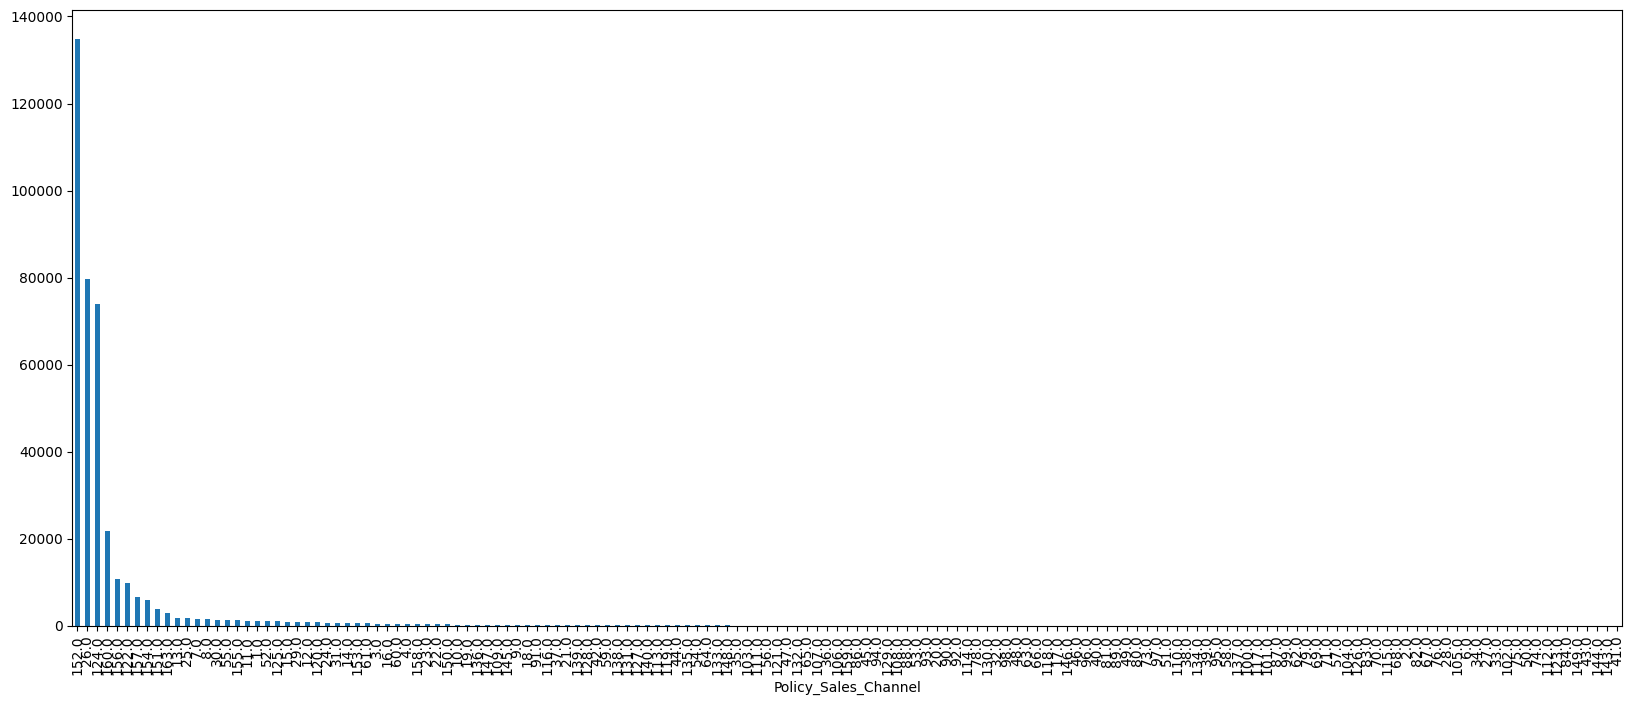

In [109]:
df2['Policy_Sales_Channel'].value_counts().sort_values(ascending=False).plot.bar(figsize=(20, 8))

<Axes: xlabel='Policy_Channel_Grouped'>

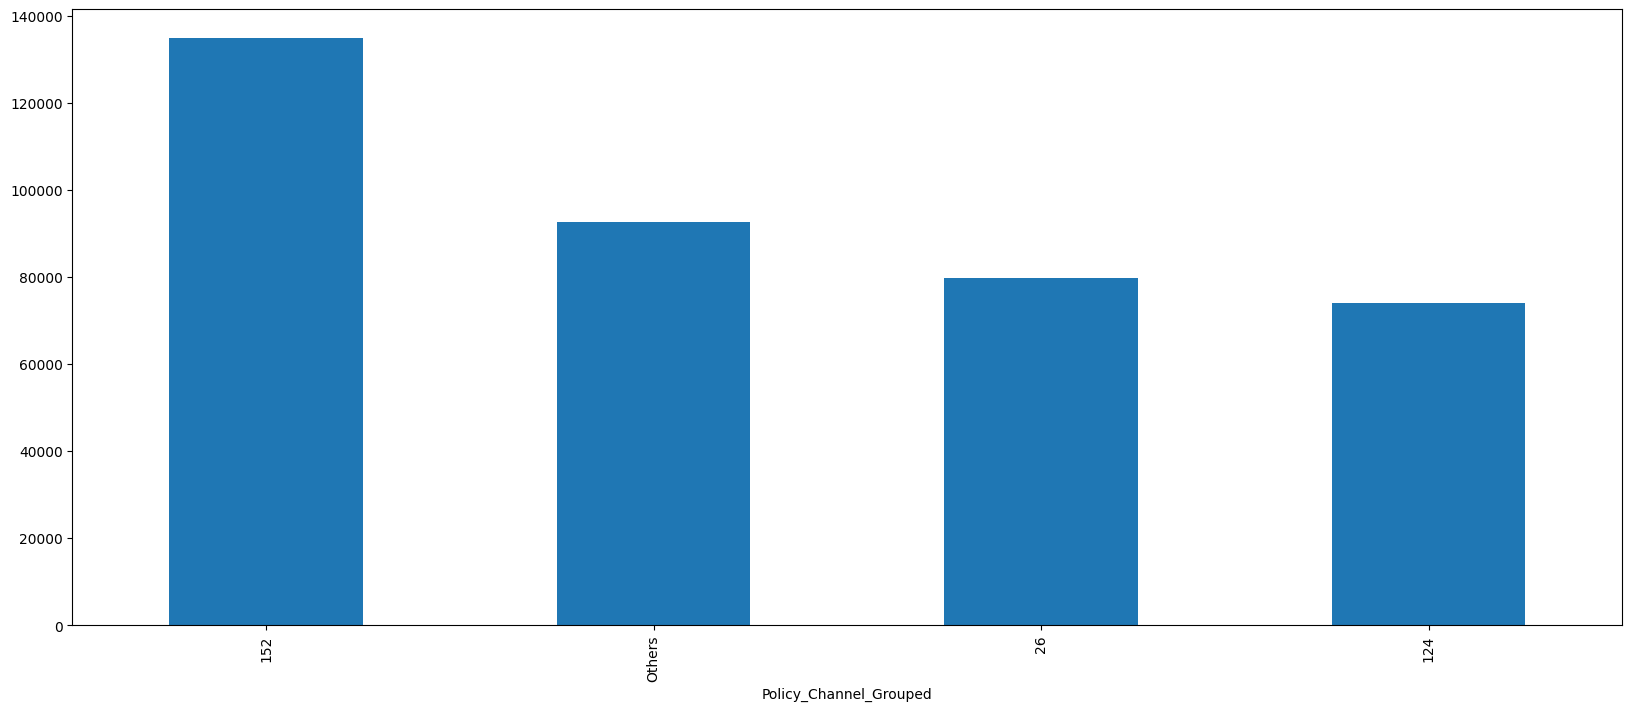

In [110]:
threshold = 40000
frequency = df2['Policy_Sales_Channel'].value_counts()
frequent= frequency[frequency > threshold].index
df2['Policy_Channel_Grouped'] = df2['Policy_Sales_Channel'].apply(lambda x: str(int(x)) if x in frequent else 'Others')
df2['Policy_Channel_Grouped'].value_counts().sort_values(ascending=False).plot.bar(figsize=(20, 8))

<Axes: xlabel='Region_Code'>

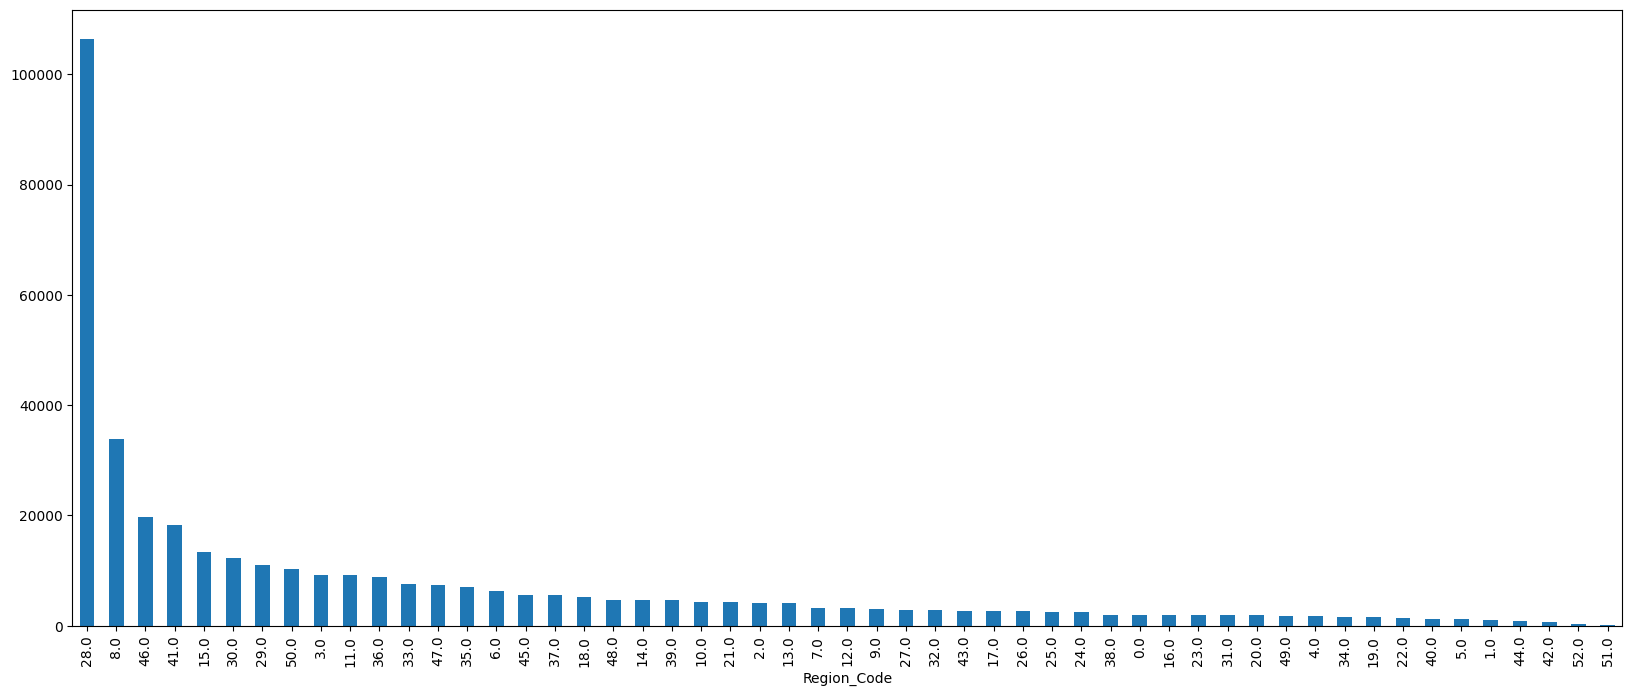

In [111]:
df['Region_Code'].value_counts().sort_values(ascending=False).plot.bar(figsize=(20, 8))

<Axes: xlabel='Region_Code_Grouped'>

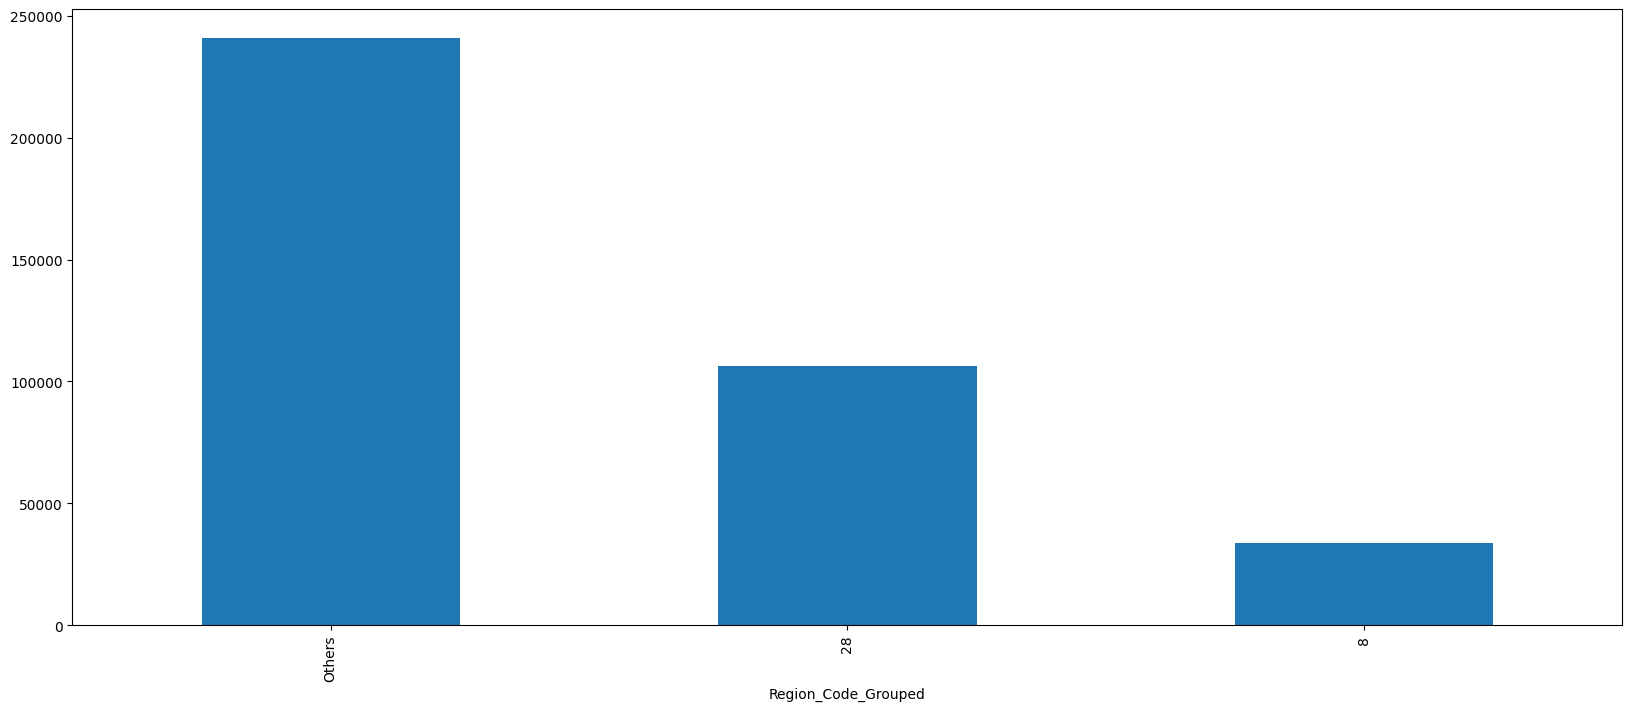

In [112]:
threshold = 20000
frequency = df2['Region_Code'].value_counts()
frequent= frequency[frequency > threshold].index
df2['Region_Code_Grouped'] = df2['Region_Code'].apply(lambda x: str(int(x)) if x in frequent else 'Others')
df2['Region_Code_Grouped'].value_counts().sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [113]:
df2.drop(columns=['Region_Code', 'Policy_Sales_Channel'], inplace=True)

In [114]:
X2 = df2.drop('Response', axis=1)
y2 = df2['Response']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y, test_size=0.3, random_state=42)

In [115]:
num_features, cat_features = variables_type(X2_train)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features),
])
X2_transformed = preprocessor.fit_transform(X2_train)
num_cols = num_features
cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
new_column_names = list(num_cols) + list(cat_cols)
X2_preprocessed = pd.DataFrame(X2_transformed, columns=new_column_names)

# Applying the Mutual Information of the data set
mi_scores = mi_score(X2_preprocessed, y_train)
mi_scores

Previously_Insured_1             0.115791
Vehicle_Damage_Yes               0.107671
Vehicle_Age_< 1 Year             0.053471
Driving_License_1                0.052370
Region_Code_Grouped_Others       0.049063
Policy_Channel_Grouped_152       0.048341
Gender_Male                      0.038436
Age                              0.031039
Policy_Channel_Grouped_26        0.011280
Policy_Channel_Grouped_Others    0.008450
Annual_Premium                   0.004460
Vehicle_Age_> 2 Years            0.004391
Region_Code_Grouped_8            0.001365
Vintage                          0.000000
dtype: float64

In [116]:
prep_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('debug_transformer', DebugTransformStep('After Preprocessing')),
    ('selector', FeatureSelectorByMI(threshold=0.03)),
    ('debug_selector', DebugTransformStep('After Feature Selection'))
])
X2_train_transf = prep_pipe.fit_transform(X2_train, y2_train)
X2_test_transf = prep_pipe.transform(X2_test)

rep_feat_sel2 =pd.DataFrame()
for name_mod, model_detail in List_Classification_Models:
    #default settings
    over=False # undersampling
    strategy=1
    over_report = '/'
    under_report = '/' 
    combine=False

    # resampling parametners based on the algorithm
    if name_mod == 'KNN':
        continue
    elif name_mod == 'LR':
        over='smote'
        strategy = 0.3
        combine = 0.5
    elif name_mod == 'XGB':
        over=True
        strategy = 0.6
    elif name_mod == 'Gauss_NB':
        over='smote'
        strategy=1
    
    #set model name parameters
    if over == 'smote':
        over_report = over + ' ' + str(strategy)
        if combine:
            under_report=combine
    elif over:
        over_report = strategy
    else:
        under_report=strategy
        
    resampling_pipe = create_debug_pipeline(num_features, cat_features, model=model_detail, 
                                            over=over, strategy=strategy, combine=combine, 
                                            debug=True      # to check the dimensions
                                            )
    steps = resampling_pipe.steps[1:]
    resampling_pipe = ImbPipeline(steps=steps)
    resampling_pipe.fit(X2_train_transf, y2_train)
    y_pred = resampling_pipe.predict(X2_test_transf)
    y_proba = resampling_pipe.predict_proba(X2_test_transf)[:,1]
    name = set_model_name(name_mod, over=over_report, under=under_report)
    rep_feat_sel2 = pd.concat([rep_feat_sel2, save_report_in_df(y2_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')

🔹 After Preprocessing - X shape: (266776, 14)
🔹 After Feature Selection - X shape: (266776, 8)
🔹 After Preprocessing - X shape: (114333, 14)
🔹 After Feature Selection - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (266776, 8)


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


🔸 After SMOTE - X shape: (304302, 8)
   Class distribution: {0: 234079, 1: 70223}
🔸 After Undersampling - X shape: (210669, 8)
   Class distribution: {0: 140446, 1: 70223}
🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model LR - smote 0.3 - 0.5.
🔹 After Preprocessing - X shape: (266776, 8)
🔸 After Undersampling - X shape: (65394, 8)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model Gaussian_NB - / - 1.
🔹 After Preprocessing - X shape: (266776, 8)
🔸 After Undersampling - X shape: (65394, 8)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model DT - / - 1.
🔹 After Preprocessing - X shape: (266776, 8)
🔸 After Undersampling - X shape: (65394, 8)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (1143

c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:00:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model XGB - 0.6 - /.


In [117]:
rep_feat_sel2.loc[rep_feat_sel2.index=='1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.297966,0.781774,0.431478,14013.0,0.747501,0.838509
1,Gaussian_NB,/,1.0,0.272508,0.910440,0.419464,14013.0,0.691130,0.826461
1,DT,/,1.0,0.276402,0.919860,0.425076,14013.0,0.695031,0.840346
1,RF,/,1.0,0.275170,0.920788,0.423716,14013.0,0.693020,0.841474
1,XGB,0.6,/,0.303830,0.832156,0.445136,14013.0,0.745734,0.847257


In [118]:
best_models.loc[best_models.index=='1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.305836,0.759580,0.436087,14013.0,0.759230,0.838810
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274
1,Gauss_NB,smote 1,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.824659
1,DT,/,1,0.260323,0.697352,0.379120,14013.0,0.720055,0.710288
1,RF,/,1,0.282065,0.836009,0.421813,14013.0,0.719101,0.833182


🔔 Considerations on improvements:

DT -> +22% recall, +13% roc_auc

RF -> + 9% recall

### 3. XGB feature importance selection on original dataset

In [119]:
#feature selection from feature importance of XGB
num_features, cat_features = variables_type(X)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features),
])
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # preprocessor già definito con ColumnTransformer
    ('classifier', model)
])

pipeline.fit(X_train, y_train)
xgb_model = pipeline.named_steps['classifier']

num_cols = num_features
cat_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = list(num_cols) + list(cat_cols)

booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')
mapped_importance = {
    feature_names[int(k[1:])]: v for k, v in importance_dict.items()
}
sorted_features = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
top_8_features = [name for name, _ in sorted_features[:8]]

print("Top 8 feature per gain:")
print(top_8_features)
all_transformed_cols=feature_names

c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:00:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top 8 feature per gain:
['Vehicle_Damage_Yes', 'Previously_Insured_1', 'Age', 'Vehicle_Age_> 2 Years', 'Policy_Sales_Channel', 'Driving_License_1', 'Vehicle_Age_< 1 Year', 'Region_Code']


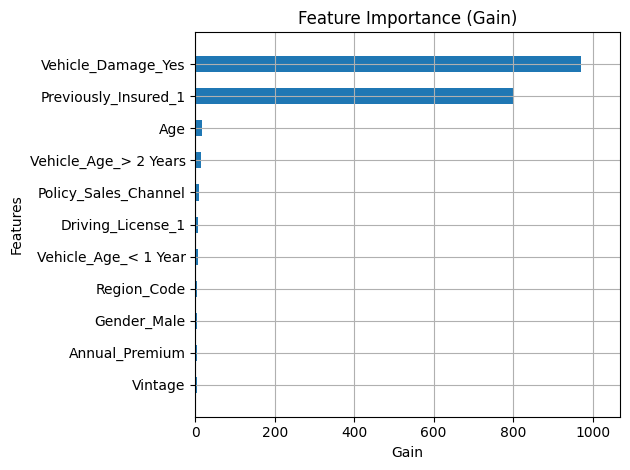

In [120]:
booster.feature_names = feature_names
xgb.plot_importance(booster, 
                    importance_type='gain', 
                    max_num_features=20, height=0.5, show_values=False)
plt.title("Feature Importance (Gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

In [121]:
prep_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('debug_transformer', DebugTransformStep('After Preprocessing', feature_names=all_transformed_cols)),
    ('selector', FeatureSelector(feature_names=top_8_features)),
    ('debug_selector', DebugTransformStep('After Feature Selection'))
])
X_train_transf = prep_pipe.fit_transform(X_train, y_train)
X_test_transf = prep_pipe.transform(X_test)


rep_feat_sel3 =pd.DataFrame()
for name_mod, model_detail in List_Classification_Models:
    #default settings
    over=False # undersampling
    strategy=1
    over_report = '/'
    under_report = '/' 
    combine=False

    # resampling parametners based on the algorithm
    if name_mod == 'KNN':
        continue
    elif name_mod == 'LR':
        over='smote'
        strategy = 0.3
        combine = 0.5
    elif name_mod == 'XGB':
        X_train_transf = clean_feature_names(X_train_transf.copy())
        X_test_transf = clean_feature_names(X_test_transf.copy())
        over=True
        strategy = 0.6
    elif name_mod == 'Gauss_NB':
        over='smote'
        strategy=1
    
    #set model name parameters
    if over == 'smote':
        over_report = over + ' ' + str(strategy)
        if combine:
            under_report=combine
    elif over:
        over_report = strategy
    else:
        under_report=strategy
        
    resampling_pipe = create_debug_pipeline(num_features, cat_features, model=model_detail, 
                                            over=over, strategy=strategy, combine=combine, 
                                            debug=True      # to check the dimensions
                                            )
    steps = resampling_pipe.steps[1:]
    resampling_pipe = ImbPipeline(steps=steps)
    resampling_pipe.fit(X_train_transf, y_train)
    y_pred = resampling_pipe.predict(X_test_transf)
    y_proba = resampling_pipe.predict_proba(X_test_transf)[:,1]
    name = set_model_name(name_mod, over=over_report, under=under_report)
    rep_feat_sel3 = pd.concat([rep_feat_sel3, save_report_in_df(y_test, y_pred, y_proba, model_name=name)])
    print(f'Finish training model {name[0]} - {name[1].get('over')} - {name[2].get('under')}.')

🔹 After Preprocessing - X shape: (266776, 11)
🔹 After Feature Selection - X shape: (266776, 8)
🔹 After Preprocessing - X shape: (114333, 11)
🔹 After Feature Selection - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (266776, 8)


c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


🔸 After SMOTE - X shape: (304302, 8)
   Class distribution: {0: 234079, 1: 70223}
🔸 After Undersampling - X shape: (210669, 8)
   Class distribution: {0: 140446, 1: 70223}
🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model LR - smote 0.3 - 0.5.
🔹 After Preprocessing - X shape: (266776, 8)
🔸 After Undersampling - X shape: (65394, 8)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model Gaussian_NB - / - 1.
🔹 After Preprocessing - X shape: (266776, 8)
🔸 After Undersampling - X shape: (65394, 8)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model DT - / - 1.
🔹 After Preprocessing - X shape: (266776, 8)
🔸 After Undersampling - X shape: (65394, 8)
   Class distribution: {0: 32697, 1: 32697}
🔹 After Preprocessing - X shape: (1143

c:\Users\Tia\Desktop\ProfessionAI\Data Science\04_Fond ML\CrossSelling_Assicurativo\cs_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:00:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 After Preprocessing - X shape: (114333, 8)
🔹 After Preprocessing - X shape: (114333, 8)
Finish training model XGB - 0.6 - /.


In [122]:
rep_feat_sel3.loc[rep_feat_sel3.index=='1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.305220,0.761579,0.435787,14013.0,0.758303,0.837371
1,Gaussian_NB,/,1.0,0.251031,0.977021,0.399434,14013.0,0.639911,0.823996
1,DT,/,1.0,0.280105,0.808892,0.416116,14013.0,0.721778,0.792106
1,RF,/,1.0,0.279571,0.848070,0.420516,14013.0,0.713530,0.830120
1,XGB,0.6,/,0.313090,0.821880,0.453443,14013.0,0.757165,0.856467


In [200]:
best_models.loc[best_models.index=='1']

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
1,LR,smote 0.3,0.5,0.305930,0.759509,0.436171,14013.0,0.759335,0.838808
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274
1,Gauss_NB,smote 1,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.824666
1,DT,/,1,0.261681,0.700992,0.381098,14013.0,0.720947,0.712360
1,RF,/,1,0.282988,0.838079,0.423108,14013.0,0.719897,0.832833


🔔 Considerations on improvements:

DT -> +10% recall, +8% roc_auc

🔔 Considerations on Feature Selection models:

Looking at the 3 reports of the models performed with feature selection we can assert that the only 2 algorithms that improve in a significant amount on the *recall* metric are the Decision Tree (+20, +22, +10 %) and Random Forest (+7, +9 %). This probably happen because with the original data those models recognize a lot of noise and giving in input less features (so less noise) is easier for them to learn. 

On the overall performances we can consider even the DT and RF with the 2nd feature selection method (grouping Policy_Sales_Channel and Region_Code and use MI to select), because are very close in the ROC AUC metric but almost 10% higher in the recall compared to our best model.


# Conclusions

## Summary of Performed Analyses

Throughout the project, several classification models were evaluated to address a highly imbalanced target variable, with the primary goal of maximizing recall to reduce false negatives and identify as many potentially interested customers as possible for marketing campaigns.

### 1. Evaluated Models
The initial models considered include:
- Logistic Regression (LR)
- K-Nearest Neighbors (KNN)
- Gaussian Naive Bayes (GaussianNB)
- Decision Tree (DT)
- Random Forest (RF)

### 2. Applied Approaches
Each model was tested under different configurations:
- Baseline: preprocessing + model without addressing class imbalance.
- Resampling: application of resampling techniques (excluding KNN due to poor baseline performance):
    - Random Oversampling
    - Random Undersampling
    - SMOTE
    - SMOTE + Random Undersampling

    Class Weights: the use of the class_weight parameter was explored for all models, but this approach yielded worse results than resampling techniques.

    *(In the field of data science the debate about handling unbalanced classes, resampling techniques (such as SMOTE or oversampling) are often effective in improving performance on unbalanced data, but they change the original distribution. For this reason, in production contexts, it is preferred to use weights in models (class_weight), which preserve the integrity of the dataset. However, in this project, resampling provided better results in terms of recall, the main objective of the analysis.)*

### 3. Best Model Selection
For each algorithm, the best-performing model after resampling was selected.

### 4. Overfitting and Underfitting
Top models were evaluated for overfitting and underfitting using multiple metrics.

### 5. Feature Selection
Feature selection was tested in three different configurations, only for the best-performing models. Decision Tree and Random Forest saw notable improvements in recall, but their F1 and ROC AUC scores remained inferior to the best models trained on the full dataset.

### 6. Final Selected Model
The best overall model was:

**XGBoost + Random Oversampling, with sampling_strategy = 0.6**

### 7. Evaluation Metrics
Model comparison was based on:
- Recall (primary metric, to minimize false negatives)
- F1-score
- ROC AUC
- Accuracy was considered only as a secondary metric, due to its limited relevance in imbalanced classification tasks.



In [123]:
best_models

,Model,over,under,precision,recall,f1-score,support,accuracy,roc_auc
0,LR,smote 0.3,0.5,0.957639,0.759181,0.846939,100320.0,0.759230,0.838810
1,LR,smote 0.3,0.5,0.305836,0.759580,0.436087,14013.0,0.759230,0.838810
macro avg,LR,smote 0.3,0.5,0.631737,0.759381,0.641513,114333.0,0.759230,0.838810
weighted avg,LR,smote 0.3,0.5,0.877752,0.759230,0.796584,114333.0,0.759230,0.838810
0,XGB,0.6,/,0.965333,0.758602,0.849572,100320.0,0.764285,0.856274
1,XGB,0.6,/,0.317773,0.804967,0.455666,14013.0,0.764285,0.856274
macro avg,XGB,0.6,/,0.641553,0.781785,0.652619,114333.0,0.764285,0.856274
weighted avg,XGB,0.6,/,0.885966,0.764285,0.801294,114333.0,0.764285,0.856274
0,Gauss_NB,smote 1,/,0.994615,0.592823,0.742871,100320.0,0.639911,0.824659
1,Gauss_NB,smote 1,/,0.251031,0.977021,0.399434,14013.0,0.639911,0.824659


## Case Study

**Cost-Benefit Estimation Using the Best Model**

To demonstrate the practical value of the model, we simulate a business scenario using the best-performing classifier: XGBoost with Random Oversampling (sampling_strategy = 0.6). The model’s key performance metrics are:
- Precision: 31.8%
- Recall: 80.5%
- F1-score: 45.6%
- Accuracy: 76.4%
- ROC AUC: 85.6%

Assume we apply this model to a future campaign involving 100,000 customers:
- The actual proportion of positives (interested clients) remains around 12% → so 12,000 customers would accept the offer.
- The model predicts positive for approximately (TP + FP) = 30,000 customers (because with 31.8% precision and 80.5% recall, the confusion matrix components are estimated as follows):
    - True Positives (TP) ≈ 9,660
    - False Negatives (FN) ≈ 2,340
    - False Positives (FP) ≈ 20,340
    - True Negatives (TN) ≈ 67,660

Assumptions for the cost-revenue structure:
- Cost per contacted customer (email/call/SMS): €1
- Revenue per successful conversion (TP): €100

Without model (targeting everyone):
- Cost: 100,000 × €1 = €100,000
- Revenue: 12,000 × €100 = €1,200,000
- Net gain: €1,100,000

With model-based targeting (only the predicted 30,000 positives):
- Cost: 30,000 × €1 = €30,000
- Revenue: 9,660 × €100 = €966,000
- Net gain: €936,000

Even though the model does not capture all the positives (about 20% are missed), the cost reduction is substantial (70% fewer contacts), resulting in a higher ROI and making the campaign much more efficient. This illustrates how the model, by prioritizing likely responders, can significantly optimize marketing efforts and maximize profitability.

## Future Developments

**Possible Strategies to Further Improve the Classification Model**:
- Perform more extensive hyperparameter tuning using grid search or Bayesian optimization.
- Apply feature selection techniques to reduce noise and improve generalization.
- Perform feature engineering to create new, more informative variables based on domain knowledge.
- Evaluate different resampling strategies.
- Use cross-validation (e.g., stratified k-fold) to better assess model robustness and reduce overfitting.
- Experiment with other algorithms such as neural networks to compare performance.
- Integrate class_weight balancing instead of resampling for algorithms that support it natively, to avoid altering data distributions.
- Monitor and implement a proper MLOps pipeline to ensure continuous performance evaluation, logging, versioning, and automated retraining.

### MLops strategy suggested

With new data available

✅ Expected Benefits:
- Improved generalization: more real data, especially from the minority class (RESPONSE=1), enhances the model’s ability to capture generalizable patterns.
- Increased precision: if new data includes additional positive examples, the model learns to distinguish them better → fewer false positives.
- Reduced overfitting: a larger dataset tends to make the model more robust against noise.

⚠️ Risks to monitor:
- If the new data is imbalanced or introduces concept drift (i.e., customer behavior changes over time), the model’s performance may deteriorate.
- Resampling techniques might become less necessary with a sufficiently large dataset, or may need to be adjusted (e.g., updating the sampling_strategy).

**Retraining Loop** to ensure that your model remains up-to-date, reliable, and performs well over time:
1. *Data Collection*:
    Continuously collect new data on customer behavior, responses to marketing campaigns, and other relevant features.
2. *Data Validation*: 
    Periodically validate the quality of incoming data (e.g., missing values, outliers, consistency with previous distributions).
3. *Preprocessing & Feature Engineering*:
    Apply the same preprocessing and feature engineering pipeline used in the original training phase, ensuring consistency.
4. *Model Evaluation with Updated Data*: 
    Use the updated dataset (e.g., every month or quarter) to evaluate current model performance on a validation set.
    If the drop in metrics (especially recall or ROC AUC) exceeds a predefined threshold, trigger a retraining process.
5. *Model Retraining*:
    Retrain the model from scratch or with incremental learning techniques using the updated dataset.
    Apply cross-validation and monitor metrics (recall, F1-score, ROC AUC) during the training process.
6. *Comparison and Deployment*:
    Compare the newly trained model to the existing one. Deploy the new model only if performance has improved or remained stable.
    Version the model and log performance and data schema for traceability.
7. *Monitoring in Production*:
    Once deployed, monitor the model in production for performance drift, prediction consistency, and stability of key metrics.
    Optionally implement real-time alerts for anomalous behavior.